            Time      Ampl
0        -0.0032  0.000000
1        -0.0032  0.000166
2        -0.0032 -0.000332
3        -0.0032  0.000498
4        -0.0032  0.000332
...          ...       ...
15999997  0.0032 -0.000166
15999998  0.0032  0.000498
15999999  0.0032  0.000000
16000000  0.0032 -0.000166
16000001  0.0032  0.000332

[16000002 rows x 2 columns]
            Time      Ampl
0        -0.0032  0.004815
1        -0.0032  0.004981
2        -0.0032  0.004815
3        -0.0032  0.004649
4        -0.0032  0.004649
...          ...       ...
15999997  0.0032  0.005313
15999998  0.0032  0.004649
15999999  0.0032  0.004981
16000000  0.0032  0.005313
16000001  0.0032  0.004981

[16000002 rows x 2 columns]
            Time      Ampl
0        -0.0032 -0.009724
1        -0.0032 -0.042933
2        -0.0032 -0.009724
3        -0.0032  0.023486
4        -0.0032  0.023486
...          ...       ...
15999997  0.0032 -0.009724
15999998  0.0032  0.023486
15999999  0.0032 -0.042933
16000000  0.0032 -0.0097

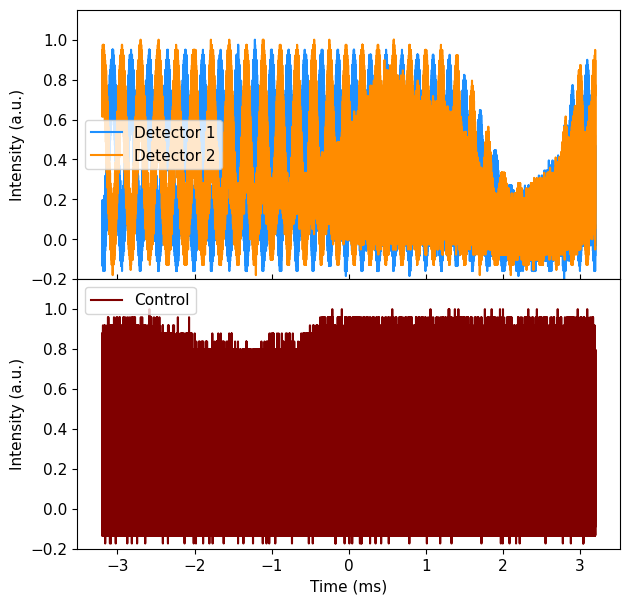

In [51]:
#In this python script we aim to extract the data from a csv file from the 1 GHz oscilloscope for the
#interferometer traces using a CW signal and a pulsed control field 

import cmath as cmath
import numpy as np
import scipy as sp
import csv
from scipy import integrate
from scipy.signal import chirp, find_peaks, peak_widths, find_peaks_cwt
import pandas as pd
import matplotlib.pyplot as plt 
from math import pi
from scipy import optimize
from scipy import ndimage
#fig, ax = plt.subplots()
#import first detector trace

plt.rcParams.update({'font.size': 11})

dataCH1= pd.read_csv(r"CH1.csv", sep=',', encoding='latin-1', skiprows=4 )
print(dataCH1)  #importing the data into a dataframe using pandas from a csv file

tCH1 = dataCH1["Time"]  #setting each column as a variable
yCH1 = dataCH1["Ampl"]

#plt.plot(tCH1*10**9, yCH1)  #plotting the data from the dataframe for detector channel 1 

#import second detector trace

dataCH3= pd.read_csv(r"CH3.csv", sep=',', encoding='latin-1', skiprows=4 )
print(dataCH3)  #importing the data into a dataframe using pandas from a csv file

tCH3 = dataCH3["Time"]  #setting each column as a variable
yCH3 = dataCH3["Ampl"]

#plt.plot(tCH3*10**9, yCH3)  #plotting the data from the dataframe for detector channel 3 

#import control trace

dataCH4= pd.read_csv(r"CH4.csv", sep=',', encoding='latin-1', skiprows=4 )
print(dataCH4)  #importing the data into a dataframe using pandas from a csv file

#CH4 in this script is the control, CH1 and CH3 are for the detector traces 

tCH4 = dataCH4["Time"]  #setting each column as a variable
yCH4 = dataCH4["Ampl"]

#Control, = ax.plot(tCH4*10**3, yCH4)  #plotting the data from the dataframe for control detector

#Adding offset and scaling CH1 to match CH3 detector response 

yCH1 = 1.0008*1.03*yCH1+0.000117+1.19*10**-6

#Calculating the sum of the two detector channels
tCHSum1and3 = tCH1 
toriginal = tCH1 

yCHSum1and3 =np.add(yCH1,yCH3)

fig, axs = plt.subplots(2,sharex='all')

tCH1np = tCH1.to_numpy()

maxyCH1 = max(yCH1)
maxyCH3 = max(yCH3)
maxyCH4 = max(yCH4)

D1, = axs[0].plot(tCH1np*10**3, yCH1/maxyCH1, color = 'dodgerblue')
D2, = axs[0].plot(tCH1np*10**3, yCH3/maxyCH3, color = 'darkorange')
Control, = axs[1].plot(tCH4*10**3, yCH4/maxyCH4, color = 'maroon')

axs[1].set_xlabel("Time (ms)")

axs[0].set_ylabel("Intensity (a.u.)")
axs[1].set_ylabel("Intensity (a.u.)")

axs[0].set_ylim([-0.2, 1.15])
axs[1].set_ylim([-0.2, 1.15])

axs[0].legend([D1, D2], ['Detector 1', 'Detector 2'], loc='center left')
axs[1].legend([Control], ['Control'], loc='upper left')

fig.subplots_adjust(hspace=0)

axs[0].tick_params(axis="x",direction="in", pad=-15)

fig.patch.set_facecolor('white')
fig.patch.set_alpha(1)

fig.set_figheight(7)
fig.set_figwidth(7)

#fig.tight_layout()

#plt.savefig('Oscilloscope data from CW interferometer being analysed 47nJ 193.1694 THz subplots.png', dpi=400, bbox_inches='tight', pad_inches = 0)
#plt.savefig('Oscilloscope data from CW interferometer being analysed 47nJ 193.1694 THz subplots.pdf', dpi=400, bbox_inches='tight', pad_inches = 0)

[13444942]
[3059187.89564015] width of single photon resonance in samples
[-0.00381065] Amplitude single photon resonance in samples
[12105235.99408389] Index of left side of peak at single photon resonance in samples
[15164423.88972404] Index of right side of peak at single photon resonance in samples
[12105235] Index of start of peak
[15164423] Index of end of peak
[13634829] IndexCentreSinglePhotonResonance
0.002255931513 CentreTimeSinglePhotonResonance


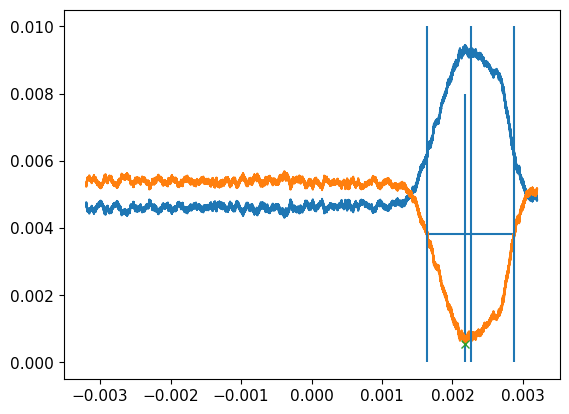

In [52]:
#We find the single photon resonance peak
#what we find is the larger of the two peaks, which is off to one side
#we want to work out the width of this peak, and then take the centre of the peak 
#and use the centre of the peak then as our 0 detuning 

#signal filtering with a bandpass

SampleRate = 2.5*10**9 #2.5 Gigasamples per second 

sos = sp.signal.iirfilter(4, Wn=[0.0000000000001,1*10**6], btype="bandpass",
                             ftype="butter", output="sos", fs=SampleRate)
yCHSum1and3filt = sp.signal.sosfilt(sos, yCHSum1and3)

yCHSum1and3filtoriginal = yCHSum1and3filt

#deleting the start of the data as the filtering makes a weird extra peak at the start of the trace 

deletestart = np.arange(5000)

yCHSum1and3filt1 = np.delete(yCHSum1and3filt, deletestart) 
yCHSum1and3filt = yCHSum1and3filt1

tCHSum1and311 = np.asarray(tCHSum1and3)

tCHSum1and31 = np.delete(tCHSum1and311, deletestart) 
tCHSum1and3 = tCHSum1and31

#finding some peaks for single photon resonance 

MaximumSummedChannelValue = max(yCHSum1and3filt)

peaksSP, _ = find_peaks(-yCHSum1and3filt, prominence=0.001, width = 100000) #finding the peaks in the trace
#for single photon resonance

print(peaksSP)

SinglePhotonResonanceWidth = peak_widths(-yCHSum1and3filt, peaksSP, rel_height=0.7) #peak width at a resonance relative height

SinglePhotonResonanceFullWidth = peak_widths(-yCHSum1and3filt, peaksSP, rel_height=0.98) #based width of the single photon peak 

print(SinglePhotonResonanceWidth[0], 'width of single photon resonance in samples')
print(SinglePhotonResonanceWidth[1], 'Amplitude single photon resonance in samples')
print(SinglePhotonResonanceWidth[2], 'Index of left side of peak at single photon resonance in samples')
print(SinglePhotonResonanceWidth[3], 'Index of right side of peak at single photon resonance in samples')

PeakStartIndex = (SinglePhotonResonanceWidth[2]).astype(int)
PeakEndIndex = (SinglePhotonResonanceWidth[3]).astype(int)

print(PeakStartIndex, 'Index of start of peak')
print(PeakEndIndex, 'Index of end of peak')

plt.plot(tCHSum1and3, -yCHSum1and3filt+0.01)

plt.hlines(y=-SinglePhotonResonanceWidth[1],xmin=tCHSum1and3[PeakStartIndex], xmax=tCHSum1and3[PeakEndIndex])
plt.vlines(x=[tCHSum1and3[peaksSP]], ymin = 0, ymax = 0.008)
plt.plot(tCHSum1and3, yCHSum1and3filt)  #plotting the data from the dataframe for the sum of both channels 
plt.plot(tCHSum1and3[peaksSP], yCHSum1and3filt[peaksSP], "x") #plotting the peaks

IndexCentreSinglePhotonResonance = ((PeakStartIndex+PeakEndIndex)/2).astype(int)
print(IndexCentreSinglePhotonResonance,'IndexCentreSinglePhotonResonance')

plt.vlines(x=[tCHSum1and3[IndexCentreSinglePhotonResonance]], ymin = 0, ymax = 0.01)
#we plot some lines for the centre of the peak, the sides, and the height at which the width is evaluated

CentreTimeSinglePhotonResonance = tCHSum1and3[IndexCentreSinglePhotonResonance[0]]

print(CentreTimeSinglePhotonResonance,'CentreTimeSinglePhotonResonance')

#plotting the line through the centre of the single photon resonance

#Next we calculate the detuning of each time index, relative to 0 detuning
#at the centre of the single photon resonance

BaseOfPeakStart = int(PeakStartIndex)
BaseOfPeakEnd = int(PeakEndIndex)

IndicesAroundPeak = [BaseOfPeakStart,BaseOfPeakEnd]

plt.vlines(x=[tCHSum1and3[IndicesAroundPeak]], ymin = 0, ymax = 0.01)

yCHSum1and3filt = yCHSum1and3filtoriginal


[  344633   932187  1544617  2124395  2694776  3259706  3839563  4389563
  4957087  5497003  6047146  6582049  7114682  7647041  8157111  8689589
  9214641  9732003 10237092 10729524 11264639 11749656 12262097 12746800
 13193949 13781260 14271418 14792060 15264542 15724625] peaksFSR
206.75862068965517 the free spectral range for the interferometer in MHz
30 len(peaksFSR)
205.06656003333336 TimeBetweenPeaks in us
1008251275371.5027
0.002255931513 CentreTimeSinglePhotonResonance


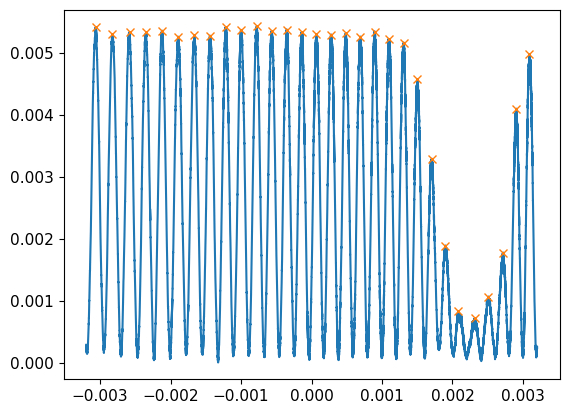

In [53]:
#Find the interferometer peaks for channel 1 

#stick channel 1 data through bandpass

sos = sp.signal.iirfilter(4, Wn=[0.0000000000001,1*10**6], btype="bandpass",
                             ftype="butter", output="sos", fs=SampleRate)
yCH1filt = sp.signal.sosfilt(sos, yCH1)

yCH1filtoriginal = yCH1filt

#yCH1np = yCH1.to_numpy()

#deleting the start of the data as the filtering makes a weird extra peak at the start of the trace 

tCH1np = tCH1.to_numpy()

yCH1filt1 = np.delete(yCH1filt, deletestart) 
yCH1filt = yCH1filt1

tCH1np1 = np.delete(tCH1np, deletestart) 
tCH1np = tCH1np1

#find the peaks

peaksFSR, _ = find_peaks(yCH1filt, height = 0.0005, width = 50000)
print(peaksFSR, 'peaksFSR')

plt.plot(tCH1np, yCH1filt)
plt.plot(tCH1np[peaksFSR], yCH1filt[peaksFSR], "x")

c = 2.998*10**8
L = 1 
n = 1.45

#FSR = 200*10**6 #200 MHz for our interferometer with 1m length and 1.45 refractive index
FSR = c/n*L 
print(FSR*10**-6, 'the free spectral range for the interferometer in MHz')

FirstPeakTime = tCH1np[peaksFSR[0]]
LastPeakTime = tCH1np[peaksFSR[-1]]
print(len(peaksFSR), 'len(peaksFSR)')
TimeBetweenPeaks = (LastPeakTime - FirstPeakTime)/len(peaksFSR)
print(TimeBetweenPeaks*10**6,'TimeBetweenPeaks in us')

#working out the distance between adjacent peaks in time, which we then use the FSR to convert to frequency

TimeToFrequencyFactor =  FSR/((LastPeakTime-FirstPeakTime)/len(peaksFSR))  #FrequencyStep/TimeStep
print(TimeToFrequencyFactor)
print(CentreTimeSinglePhotonResonance,'CentreTimeSinglePhotonResonance')

tCH1np = toriginal.to_numpy()

TimeToFrequency = (tCH1np-CentreTimeSinglePhotonResonance)*TimeToFrequencyFactor

#Detuning = (tCHSum1and3-tCHSum1and3[IndexCentreSinglePhotonResonance])/TimeToFrequency

Text(0, 0.5, 'Amplitude of channel (mV)')

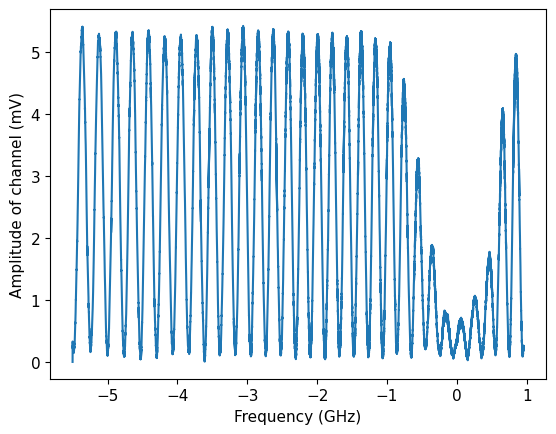

In [54]:
#Plotting channel 1 data with the x axis converted to frequency from time 

yCH1filt = yCH1filtoriginal

plt.plot(TimeToFrequency*10**-9, yCH1filt*10**3)
plt.xlabel("Frequency (GHz)")

plt.ylabel("Amplitude of channel (mV)")

1e-06 Time between pulses in seconds
4e-10 Time between samples in seconds
2500.0
6400.0008 PredictedNumberOfControlPulsesInTrace
[    1977     4479     6981 ... 15994434 15996928 15999433] peaksControl
6400 Number of Control Peaks detected
16000002 Number of elements in tCH4
1977        0.720882
4479        0.720882
6981        0.654463
9483        0.654463
11977       0.687673
              ...   
15989429    0.720882
15991927    0.654463
15994434    0.654463
15996928    0.654463
15999433    0.654463
Name: Ampl, Length: 6400, dtype: float64
[10.02778001 10.27083478 10.76970374 ... 10.96500487 10.66323848
 10.87942071] width of channel 4 control peak in samples
[0.1397182 0.1397182 0.1197925 ... 0.1197925 0.1197925 0.1197925] Amplitude of evaluation for channel 4 control peak width in samples
[1.97591667e+03 4.47756250e+03 6.97526364e+03 ... 1.59944271e+07
 1.59969261e+07 1.59994272e+07] Index of left side of peak at amplitude of evaluation channel 4 control in samples
[1.98594445e+03

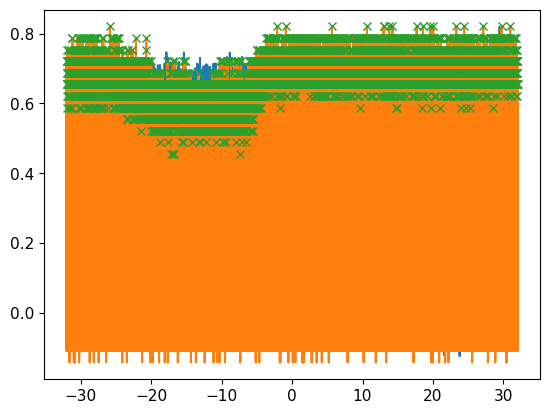

In [55]:
#Finding the positions of the control peaks 

#Find position of each control field peak, should use find peaks on channel 4 with a peak width set to some ns 
#written in terms of the number of samples, 5 samples per nanosecond at 5 gigasamples per second
#that should then get us consistently the centre position of the control pulse peak
#we can then select a range of data for both detector channels for both peaks, delayed in time by a constant 
#relative to the control field
#that will allow us to calculate a range of absorption and phase shift values that we can then take an average 
#and standard deviation for 
#this should then give us a robust analysis 
#when this is working it should then be easy for us to take big data files for a given set of experimental settings
#then we can plot the phase shift and absorption as a function of the signal detuning at all other
#parameters fixed 
#this will then allow us to produce plots for different control detunings, temperatures, etc. 

tCHSum1and3 = tCH1np = toriginal.to_numpy() #redefining the times at the original times with all data points
#the data points were previously cut out for looking at the bandpass filtered data above
#as the band pass filter adds a weird feature at the start of the trace. This is not present in the unfiltered data
#and so we wish to use all the data for the unfiltered parts 

FrequencyControlPulses = 1*10**6 #1 MHz repetition frequency of control pulses
SampleRate = SampleRate #5 GigaSamples per second
TimeBetweenSamples = 1/SampleRate
TimeBetweenPulses = 1/FrequencyControlPulses
NumberOfSamplesBetweenPulses = TimeBetweenPulses*(1/TimeBetweenSamples)

print(TimeBetweenPulses, 'Time between pulses in seconds')
print(TimeBetweenSamples, 'Time between samples in seconds')
print(NumberOfSamplesBetweenPulses)

PredictedNumberOfControlPulsesInTrace = len(tCH4)/NumberOfSamplesBetweenPulses
print(PredictedNumberOfControlPulsesInTrace, 'PredictedNumberOfControlPulsesInTrace')

peaksControl, _ = find_peaks(yCH4, prominence = 0.05, distance=2000, width = 6)
print(peaksControl, 'peaksControl')

print(len(peaksControl), 'Number of Control Peaks detected')
print(len(tCH4), 'Number of elements in tCH4')

#1 MHz in samples? 1 MHz is 1000ns between pulses
#2.5 samples per ns at 2.5GSamples/s

plt.plot(tCH1np*10**4, yCHSum1and3*100)
plt.plot(tCH4*10**4, yCH4)
plt.plot((tCH4[peaksControl])*10**4, yCH4[peaksControl], "x")
#plt.plot(tCH1*10**4, yCH1*10**2)
#plt.plot(tCH3*10**4, yCH3*10**2)

#it looks like we have now successfully found all of the control peaks
#what we need to do next is work out what the spacing between the control peak and each of the switching peaks is

#we should use the peak widths and find the centre of the peak width for each control peak
#in order to find the centre of each peak 

####
#working out the centre of the control peak
###

tCH4np = tCH4.to_numpy()

peaksCH4 = peaksControl


#plt.plot(tCH4np, yCH4)
#plt.plot(tCH4np[peaksCH4], yCH4[peaksCH4], "x")

results_halfControl = peak_widths(yCH4, peaksCH4, rel_height=0.7)

results_halfControl[0]  # widths
print(yCH4[peaksCH4])
print(results_halfControl[0], 'width of channel 4 control peak in samples')
print(results_halfControl[1], 'Amplitude of evaluation for channel 4 control peak width in samples')
print(results_halfControl[2], 'Index of left side of peak at amplitude of evaluation channel 4 control in samples')
print(results_halfControl[3], 'Index of right side of peak at amplitude of evaluation channel 4 control in samples')

IndexCentreControlPeak = (((results_halfControl[3]-results_halfControl[2])/2)+results_halfControl[2]).astype(int)
print(IndexCentreControlPeak, 'This is the index for the centre of the control pulse')

IndexLeftSidePeak = results_halfControl[2].astype(int)
IndexRightSidePeak = results_halfControl[3].astype(int)

#at 5 GSamples/s
#it looks like channel 3 is ahead by around 7 index steps for the first peak
#channel 3 is ahead by around 33 index steps for the second peak
#it then looks like channel 1 is 9 index steps ahead for the first peak
#and then channel 1 is 35 index steps ahead for the second peak 
#from analysis in 'Extracting phase and loss information from CW interferometer switching with pulsed control v3'

IndexCentreControlPeak 

PositionsOverPeak = np.linspace(-5,5,11)
print(PositionsOverPeak)

CH3Delay1 = OffSetControlToCH3FirstPeak = int((7/2))-1
CH1Delay1 = OffSetControlToCH1FirstPeak = int((10/2))-2

print(CH3Delay1,'CH3Delay1')
print(CH1Delay1,'CH1Delay1')

CH3Delay2 = OffSetControlToCH3SecondPeak = int((33/2))-2
CH1Delay2 = OffSetControlToCH1SecondPeak = int((35/2))-3

print(CH3Delay2,'CH3Delay2')
print(CH1Delay2,'CH1Delay2')

CHSumDelay1 = int((4/2))-0
CHSumDelay2 = int((34/2))-3

print(CHSumDelay1,'CHSumDelay1')
print(CHSumDelay2,'CHSumDelay2')


for i in IndexCentreControlPeak:
    IndexCH3FirstPeak = np.array([IndexCentreControlPeak-2+CH3Delay1,IndexCentreControlPeak-1+CH3Delay1,IndexCentreControlPeak+CH3Delay1,IndexCentreControlPeak+1+CH3Delay1,IndexCentreControlPeak+2+CH3Delay1])    

for i in IndexCentreControlPeak :
    IndexCH1FirstPeak = np.array([IndexCentreControlPeak-2+CH1Delay1,IndexCentreControlPeak-1+CH1Delay1,IndexCentreControlPeak+CH1Delay1,IndexCentreControlPeak+1+CH1Delay1,IndexCentreControlPeak+2+CH1Delay1])        
    
for i in IndexCentreControlPeak :
    IndexCH3SecondPeak = np.array([IndexCentreControlPeak-2+CH3Delay2,IndexCentreControlPeak-1+CH3Delay2,IndexCentreControlPeak+CH3Delay2,IndexCentreControlPeak+1+CH3Delay2,IndexCentreControlPeak+2+CH3Delay2])    

for i in IndexCentreControlPeak :
    IndexCH1SecondPeak = np.array([IndexCentreControlPeak-2+CH1Delay2,IndexCentreControlPeak-1+CH1Delay2,IndexCentreControlPeak+CH1Delay2,IndexCentreControlPeak+1+CH1Delay2,IndexCentreControlPeak+2+CH1Delay2])        

for i in IndexCentreControlPeak :
    IndexCHSumFirstPeak = np.array([IndexCentreControlPeak-2+CHSumDelay1,IndexCentreControlPeak-1+CHSumDelay1,IndexCentreControlPeak+CHSumDelay1,IndexCentreControlPeak+1+CHSumDelay1,IndexCentreControlPeak+2+CHSumDelay1])        
    
for i in IndexCentreControlPeak :
    IndexCHSumSecondPeak = np.array([IndexCentreControlPeak-2+CHSumDelay2,IndexCentreControlPeak-1+CHSumDelay2,IndexCentreControlPeak+CHSumDelay2,IndexCentreControlPeak+1+CHSumDelay2,IndexCentreControlPeak+2+CHSumDelay2])    
        
#take a series of points 20 indices before the middle of the control pulse and beyond to work out a baseline for the channel
#before the control turns on (for working out phi, the phase between the two channels)

for i in IndexCentreControlPeak :
    IndexCH1BackGroundPoints = np.array([IndexCentreControlPeak-20,IndexCentreControlPeak-21,IndexCentreControlPeak-22, IndexCentreControlPeak-23,IndexCentreControlPeak-24,IndexCentreControlPeak-25,IndexCentreControlPeak-26,IndexCentreControlPeak-27,IndexCentreControlPeak-28,IndexCentreControlPeak-29 ,IndexCentreControlPeak-30,IndexCentreControlPeak-31,IndexCentreControlPeak-32,IndexCentreControlPeak-33,IndexCentreControlPeak-34,IndexCentreControlPeak-35,IndexCentreControlPeak-36,IndexCentreControlPeak-37,IndexCentreControlPeak-38,IndexCentreControlPeak-39])    

print(IndexCH1BackGroundPoints,'IndexCH1BackGroundPoints before deleting')    
    
IndexCH1BackGroundPoints1 = np.delete(IndexCH1BackGroundPoints, 0,1) 
IndexCH1BackGroundPoints = IndexCH1BackGroundPoints1

IndexCHSumSecondPeak1 = np.delete(IndexCHSumSecondPeak, 0,1) 
IndexCHSumSecondPeak = IndexCHSumSecondPeak1

IndexCHSumFirstPeak1 = np.delete(IndexCHSumFirstPeak, 0,1) 
IndexCHSumFirstPeak = IndexCHSumFirstPeak1

IndexCH1SecondPeak1 = np.delete(IndexCH1SecondPeak, 0,1) 
IndexCH1SecondPeak = IndexCH1SecondPeak1

IndexCH3SecondPeak1 = np.delete(IndexCH3SecondPeak, 0,1) 
IndexCH3SecondPeak = IndexCH3SecondPeak1

IndexCH1FirstPeak1 = np.delete(IndexCH1FirstPeak, 0,1) 
IndexCH1FirstPeak = IndexCH1FirstPeak1

IndexCH3FirstPeak1 = np.delete(IndexCH3FirstPeak, 0,1) 
IndexCH3FirstPeak = IndexCH3FirstPeak1

IndexCentreControlPeak1 = np.delete(IndexCentreControlPeak, [0]) 
IndexCentreControlPeak = IndexCentreControlPeak1

#deleteing the first control pulse from all the indices (deletes the first column in each)

print(IndexCH1BackGroundPoints, 'IndexCH1BackGroundPoints')
print(IndexCH1BackGroundPoints[:, 1], 'Background points for CH1')

#first index specifies if the 
print(IndexCH3FirstPeak)
print(IndexCH3FirstPeak[:, 0])

#i think we need to loop over the second indices. [:, 0] is calling the first column, [:, 1] the second column etc.
#the columns are data for the same peak, the rows are data for all the peaks at the same offset 


-1.8744926125526555 Frequency of this control pulse in GHz


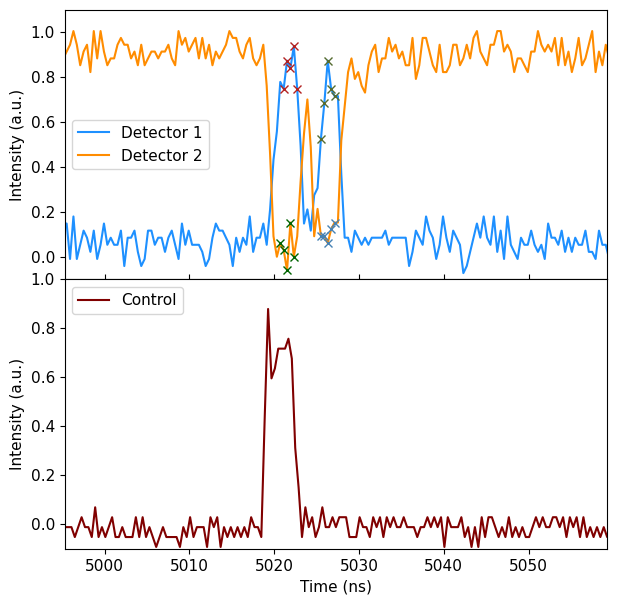

In [56]:
#looking at a close up of one control pulse specified by the number g 
#fig, ax = plt.subplots()

fig, axs = plt.subplots(2,sharex='all')

plt.rcParams.update({'font.size': 11})

sos = sp.signal.iirfilter(4, Wn=[0.0000000000001,1*10**6], btype="bandpass",
                             ftype="butter", output="sos", fs=SampleRate)
yCH1filt = sp.signal.sosfilt(sos, yCH1)
yCH3filt = sp.signal.sosfilt(sos, yCH3)

MaxForNormalisingCH1 = np.amax(yCH1filt)
MaxForNormalisingCH3 = np.amax(yCH3filt)
MaxForNormalisingCH4 = np.amax(yCH4)


D1, = axs[0].plot(tCH1np*10**9-391760, yCH1/MaxForNormalisingCH1, color = 'dodgerblue')
D2, = axs[0].plot(tCH1np*10**9-391760, yCH3/MaxForNormalisingCH3, color = 'darkorange')
Control, = axs[1].plot(tCH4*10**9-391760, yCH4/MaxForNormalisingCH4, color = 'maroon')

#plt.plot(tCH1np*10**9, yCHSum1and3*1000)
#Control, = ax.plot(tCH4*10**9, yCH4*0.5*1000*10**-2+5.4)
#D1, = ax.plot(tCH1np*10**9, yCH1*1000)
#D2, = ax.plot(tCH1np*10**9, yCH3*1000)

#plt.plot((tCH4[peaksControl])*10**9, yCH4[peaksControl]*0.5*1000*10**-2+6, "x")

columns = IndexCHSumFirstPeak.shape[1]
rows = IndexCHSumFirstPeak.shape[0]

IndexCHSumSecondPeak1d = []

for j in range(columns):
     for i in range(rows):
        IndexCHSumSecondPeak1 = IndexCHSumSecondPeak[i][j]
        IndexCHSumSecondPeak1d.append(IndexCHSumSecondPeak1)

IndexCHSumFirstPeak1d = []        
        
for j in range(columns):
     for i in range(rows):
        IndexCHSumFirstPeak1 = IndexCHSumFirstPeak[i][j]
        IndexCHSumFirstPeak1d.append(IndexCHSumFirstPeak1)  

        
IndexCH1FirstPeak1d = []

for j in range(columns):
     for i in range(rows):
        IndexCH1FirstPeak1 = IndexCH1FirstPeak[i][j]
        IndexCH1FirstPeak1d.append(IndexCH1FirstPeak1)

IndexCH3FirstPeak1d = []

for j in range(columns):
     for i in range(rows):
        IndexCH3FirstPeak1 = IndexCH3FirstPeak[i][j]
        IndexCH3FirstPeak1d.append(IndexCH3FirstPeak1)       
        
IndexCH1SecondPeak1d = []

for j in range(columns):
     for i in range(rows):
        IndexCH1SecondPeak1 = IndexCH1SecondPeak[i][j]
        IndexCH1SecondPeak1d.append(IndexCH1SecondPeak1)

IndexCH3SecondPeak1d = []

for j in range(columns):
     for i in range(rows):
        IndexCH3SecondPeak1 = IndexCH3SecondPeak[i][j]
        IndexCH3SecondPeak1d.append(IndexCH3SecondPeak1)
        
        
#plt.plot((tCH1np[IndexCHSumSecondPeak1d])*10**9, (yCHSum1and3[IndexCHSumSecondPeak1d]*1000), "x")
#plt.plot((tCH1np[IndexCHSumFirstPeak1d])*10**9, (yCHSum1and3[IndexCHSumFirstPeak1d]*1000), "x")

axs[0].plot((tCH1np[IndexCH1SecondPeak1d])*10**9-391760, (yCH1[IndexCH1SecondPeak1d]/MaxForNormalisingCH1), "x", color = 'darkolivegreen')
axs[0].plot((tCH1np[IndexCH1FirstPeak1d])*10**9-391760, (yCH1[IndexCH1FirstPeak1d]/MaxForNormalisingCH1), "x", color = 'firebrick')

axs[0].plot((tCH1np[IndexCH3SecondPeak1d])*10**9-391760, (yCH3[IndexCH3SecondPeak1d]/MaxForNormalisingCH3), "x", color = 'steelblue')
axs[0].plot((tCH1np[IndexCH3FirstPeak1d])*10**9-391760, (yCH3[IndexCH3FirstPeak1d]/MaxForNormalisingCH3), "x", color = 'darkgreen')

#plt.plot((tCH4[IndexRightSidePeak])*10**9, (yCH4[IndexRightSidePeak]), "x")
#plt.plot((tCH4[IndexLeftSidePeak])*10**9, (yCH4[IndexLeftSidePeak]), "x")
#plt.plot((tCH4[IndexCentreControlPeak])*10**9, (yCH4[IndexCentreControlPeak]), "x")


#print(IndexCHSumSecondPeak1d,'IndexCHSumSecondPeak1d')
#print((yCHSum1and3[IndexCHSumSecondPeak1d])*100, '(yCHSum1and3[IndexCHSumSecondPeak1d])*100')

m = 1
n = 0 +m*1
n2 = 0 +m*1
g = 3595

axs[0].set_xlim((tCH4[(peaksControl[1+g]-60*n2)])*10**9-391760,(tCH4[(peaksControl[1+g]+100*n)])*10**9-391760)
axs[1].set_xlim((tCH4[(peaksControl[1+g]-60*n2)])*10**9-391760,(tCH4[(peaksControl[1+g]+100*n)])*10**9-391760)

print(((tCH4[(peaksControl[1+g])]-CentreTimeSinglePhotonResonance)*TimeToFrequencyFactor*10**-9), 'Frequency of this control pulse in GHz')

#plot the peaks positions of the peaks relative to the control? 

#Duration of pulse
#print(IndexRightSidePeak-IndexLeftSidePeak,'control pulse duration')

#checking time difference between control pulses

#print(((-tCH4[peaksControl[0]]+tCH4[peaksControl[-1]])/len(peaksControl))*10**9,'the duration between pulses in ns')
#1000ns between pulses is 1 MHz as we expected!
#now to check the sample rate 
#
#print(((-tCH4[peaksControl[0]]+tCH4[peaksControl[-1]])/len(tCH1))*10**9,'the duration between samples in ns')

axs[1].set_xlabel("Time (ns)")

axs[0].set_ylabel("Intensity (a.u.)")
axs[1].set_ylabel("Intensity (a.u.)")

axs[0].set_ylim([-0.1, 1.1])
axs[1].set_ylim([-0.1, 1])

axs[0].legend([D1, D2], ['Detector 1', 'Detector 2'], loc='center left')
axs[1].legend([Control], ['Control'], loc='upper left')

fig.subplots_adjust(hspace=0)

axs[0].tick_params(axis="x",direction="in", pad=-15)


fig.patch.set_facecolor('white') #background colour for the figure 
fig.patch.set_alpha(1) #alpha of the background colour

#plt.xlim([-5.2, 0])
#plt.ylim([-0.1, 9.5])

fig.set_figheight(7) #sets the size of the subplot figure
fig.set_figwidth(7)

#fig.tight_layout() #makes the margins around the figure tight to the figure 

#plt.savefig('Oscilloscope data from CW interferometer being analysed 47nJ 193.1694 THz close up subplots.png', dpi=400, bbox_inches='tight', pad_inches = 0)
#plt.savefig('Oscilloscope data from CW interferometer being analysed 47nJ 193.1694 THz close up subplots.pdf', dpi=400, bbox_inches='tight', pad_inches = 0)

[4202276.63508097] full width of single photon resonance in samples
[-0.00511457] Amplitude single photon resonance full width in samples
[11464724.71740037] Index of left side of peak at single photon resonance in samples full width
[15667001.35248134] Index of right side of peak at single photon resonance in samples full width
[11464724]
[15667001]
4535278
[11464724 11464725 11464726 ... 15999999 16000000 16000001] IndicesThroughPeak
16000002 yCH3filt
11459724 yCH3filtNoSinglePhoton
16000002 tCH3np
11459724 tCH3filtNoSinglePhoton
[  629930  1234911  1827205  2406184  2980225  3546336  4131761  4682255
  5214731  5764870  6322138  6849312  7379521  7917121  8434602  8956953
  9457035  9974588 10484624 10999571] peaksFSRCH1
[   50032   637932  1236805  1814702  2414864  2982327  3562168  4127134
  4679664  5227072  5769755  6324597  6864634  7387178  7919665  8442041
  8954635  9472142  9974652 10489550 10997092] peaksFSRCH3
[0.00503941 0.00503939 0.00503937 ... 0.00450899 0.00450899 0

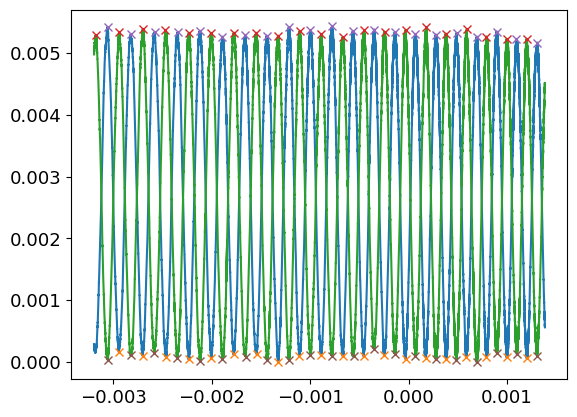

In [61]:
#Now let's work out the maximum and minimum detector powers
#we will want to remove the data around the single photon resonance 

#stick channel 1 data through bandpass

sos = sp.signal.iirfilter(4, Wn=[0.0000000000001,1*10**6], btype="bandpass",
                             ftype="butter", output="sos", fs=SampleRate)
yCH1filt = sp.signal.sosfilt(sos, yCH1)
yCH3filt = sp.signal.sosfilt(sos, yCH3)

#yCH1np = yCH1.to_numpy()

tCH1np = tCH1.to_numpy()
tCH3np = tCH3.to_numpy()

#cut out data from single photon resonance 

SinglePhotonResonanceFullWidth
print(SinglePhotonResonanceFullWidth[0], 'full width of single photon resonance in samples')
print(SinglePhotonResonanceFullWidth[1], 'Amplitude single photon resonance full width in samples')
print(SinglePhotonResonanceFullWidth[2], 'Index of left side of peak at single photon resonance in samples full width')
print(SinglePhotonResonanceFullWidth[3], 'Index of right side of peak at single photon resonance in samples full width')

PeakStartIndexInt = SinglePhotonResonanceFullWidth[2].astype(int)
PeakEndIndexInt = SinglePhotonResonanceFullWidth[3].astype(int)

print(PeakStartIndexInt)
print(PeakEndIndexInt)

PeakEndIndexInt = (len(tCH1np))
NumberOfIndices = ((len(tCH1np))-PeakStartIndexInt)
#NumberOfIndices = (PeakEndIndex-PeakStartIndex)

print(NumberOfIndices[0])

#IndicesThroughPeak = (np.linspace(PeakStartIndexInt, PeakEndIndexInt, NumberOfIndices[0])).astype(int)
IndicesThroughPeak = np.arange(PeakStartIndexInt,PeakEndIndexInt,1)

print(IndicesThroughPeak, 'IndicesThroughPeak')

yCH1filtNoSinglePhoton = np.delete(yCH1filt, IndicesThroughPeak)
tCH1filtNoSinglePhoton = np.delete(tCH1np, IndicesThroughPeak)

yCH3filtNoSinglePhoton = np.delete(yCH3filt, IndicesThroughPeak)
tCH3filtNoSinglePhoton = np.delete(tCH3np, IndicesThroughPeak)

yCH1filtNoSinglePhoton1 = np.delete(yCH1filtNoSinglePhoton, deletestart) 
yCH1filtNoSinglePhoton = yCH1filtNoSinglePhoton1

yCH3filtNoSinglePhoton1 = np.delete(yCH3filtNoSinglePhoton, deletestart) 
yCH3filtNoSinglePhoton = yCH3filtNoSinglePhoton1

tCH1filtNoSinglePhoton1 = np.delete(tCH1filtNoSinglePhoton, deletestart) 
tCH1filtNoSinglePhoton = tCH1filtNoSinglePhoton1

tCH3filtNoSinglePhoton1 = np.delete(tCH3filtNoSinglePhoton, deletestart) 
tCH3filtNoSinglePhoton = tCH3filtNoSinglePhoton1


print(len(yCH3filt),'yCH3filt')
print(len(yCH3filtNoSinglePhoton),'yCH3filtNoSinglePhoton')
print(len(tCH3np),'tCH3np')
print(len(tCH3filtNoSinglePhoton),'tCH3filtNoSinglePhoton')

#find the peaks

peaksFSRCH1, _ = find_peaks(-yCH1filtNoSinglePhoton, width = 50000)
peaksFSRCH3, _ = find_peaks(yCH3filtNoSinglePhoton, width = 50000)
peaksFSRCH12, _ = find_peaks(yCH1filtNoSinglePhoton, width = 50000)
peaksFSRCH32, _ = find_peaks(-yCH3filtNoSinglePhoton, width = 50000)
print(peaksFSRCH1, 'peaksFSRCH1')
print(peaksFSRCH3, 'peaksFSRCH3')

print(yCH3filtNoSinglePhoton,'yCH3filtNoSinglePhoton')
print(tCH3filtNoSinglePhoton,'tCH3filtNoSinglePhoton')

print(yCH3filt[peaksFSRCH3],'yCH3filt[peaksFSRCH3]')


print(np.mean(yCH3filtNoSinglePhoton[peaksFSRCH3]),'yCH3filtNoSinglePhoton[peaksFSRCH3]')

print(len(yCH3filtNoSinglePhoton[peaksFSRCH3]),'len(yCH3filtNoSinglePhoton[peaksFSRCH3]')
print(len(yCH3filtNoSinglePhoton[peaksFSRCH3]),'len(yCH3filtNoSinglePhoton[peaksFSRCH3]')

print(yCH1filtNoSinglePhoton[peaksFSRCH12],'yCH3filtNoSinglePhoton[peaksFSRCH12]')
print(yCH3filtNoSinglePhoton[peaksFSRCH32],'yCH3filtNoSinglePhoton[peaksFSRCH32]')

print(np.mean(yCH1filtNoSinglePhoton[peaksFSRCH1]),'yCH1filtNoSinglePhoton[peaksFSRCH1]')
print(len(yCH1filtNoSinglePhoton[peaksFSRCH1]),'len(yCH1filtNoSinglePhoton[peaksFSRCH1]')
print(yCH1filtNoSinglePhoton[peaksFSRCH1],'yCH1filtNoSinglePhoton[peaksFSRCH1]')


plt.plot(tCH1filtNoSinglePhoton, yCH1filtNoSinglePhoton)
plt.plot(tCH1filtNoSinglePhoton[peaksFSRCH1], yCH1filtNoSinglePhoton[peaksFSRCH1], "x")
plt.plot(tCH3filtNoSinglePhoton, yCH3filtNoSinglePhoton)
plt.plot(tCH3filtNoSinglePhoton[peaksFSRCH3], yCH3filtNoSinglePhoton[peaksFSRCH3], "x")

plt.plot(tCH1filtNoSinglePhoton[peaksFSRCH12], yCH1filtNoSinglePhoton[peaksFSRCH12], "x")

plt.plot(tCH3filtNoSinglePhoton[peaksFSRCH32], yCH3filtNoSinglePhoton[peaksFSRCH32], "x")

#The amplitude of the peaks in channel 1 and channel 3 are almost exactly the same
#for example for a channel 1 amplitude of '0.008115523105908521 yCH1filtNoSinglePhoton[peaksFSRCH1]'
#we get a channel 3 amplitude of '0.008106313474273017 yCH3filtNoSinglePhoton[peaksFSRCH3]'
#less than 1% difference between these values! We are safe to ignore this effect!

#We define the Peak amplitude for Detector 1 as np.mean(yCH1filtNoSinglePhoton[peaksFSRCH1]
#and we define the minimum amplitude for detector 1 as np.mean(yCH3filtNoSinglePhoton[peaksFSRCH3]
#as both channels have the same maxima and minima values!

MeanYpeaksFSRCH3 = np.mean(yCH3filtNoSinglePhoton[peaksFSRCH3])
MeanYpeaksFSRCH12 = np.mean(yCH1filtNoSinglePhoton[peaksFSRCH12])

PD1MIN = (MeanYpeaksFSRCH3+MeanYpeaksFSRCH12)/2 #average of the minima peaks (no single photon absorption)

print(PD1MIN, 'Amplitude of the minima (V)')

MeanYpeaksFSRCH1 = np.mean(yCH1filtNoSinglePhoton[peaksFSRCH1])
MeanYpeaksFSRCH32 = np.mean(yCH3filtNoSinglePhoton[peaksFSRCH32])


PD1MAX = (MeanYpeaksFSRCH1+MeanYpeaksFSRCH32)/2 #average of the maxima peaks (no single photon absorption)

print(PD1MAX, 'Amplitude of the maxima (V)')

DifferenceBetweenPeakAndTrough = -(PD1MAX - PD1MIN)
print(DifferenceBetweenPeakAndTrough, 'Difference Between Peak And Trough amplitudes (V)')

ConstantInfrontOfCos = DifferenceBetweenPeakAndTrough/2

print(MeanYpeaksFSRCH3*10**3,'MeanYpeaksFSRCH3 (mV)')
print(MeanYpeaksFSRCH12*10**3,'MeanYpeaksFSRCH12 (mV)')
print(MeanYpeaksFSRCH1*10**3,'MeanYpeaksFSRCH1 (mV)')
print(MeanYpeaksFSRCH32*10**3,'MeanYpeaksFSRCH32 (mV)')

OffSetMinimaBetweenChannels = MeanYpeaksFSRCH3 - MeanYpeaksFSRCH12
OffSetMaximaBetweenChannels = MeanYpeaksFSRCH1 - MeanYpeaksFSRCH32

DifferenceBetweenChannel1 = MeanYpeaksFSRCH1 - MeanYpeaksFSRCH12
DifferenceBetweenChannel3 = MeanYpeaksFSRCH3 - MeanYpeaksFSRCH32

print(OffSetMinimaBetweenChannels*10**3, 'OffSetMinimaBetweenChannels (mV)')
print(OffSetMaximaBetweenChannels*10**3, 'OffSetMaximaBetweenChannels (mV)')

print((- OffSetMaximaBetweenChannels + OffSetMinimaBetweenChannels)/2, 'Average difference in offset between two channels (V)')

print(DifferenceBetweenChannel1*10**3,'DifferenceBetweenChannel1 (mV)')
print(DifferenceBetweenChannel3*10**3,'DifferenceBetweenChannel3 (mV)')
print(DifferenceBetweenChannel3/DifferenceBetweenChannel1,'Ratio of differences between channels')

print(MeanYpeaksFSRCH3/MeanYpeaksFSRCH12,'Ratio of CH3 and CH1 peaks')

0.00502168008183593
0.005377460665303434 np.mean(ySumCH1andCH3RemoveStart)
0.005377404557719867 np.mean(ySumCH1andCH3)
0.005377460665303434
0.005377460665303434
0.005377460665303434 PD1PlusD2
0.005239946949569915 DifferenceBetweenPeakAndTrough
1 gamma
0.0032928907361412588 P2Plus
0.002084569929162175 P2minus
0.002688730332651717 This is P1, the amplitude response proportional to the power in the first interferometer arm (V)
0.005377460665303434 P1+P2
0.002688730332651717 P1*P2 square rooted
0.005377460665303434 P1*P2 square rooted and added to P1+P2 divded by 2
0.0053087038074366745 P1*P2 square rooted and added half the difference between peak and trough
0.0026199734747849577 DifferenceBetweenPeakAndTrough/2


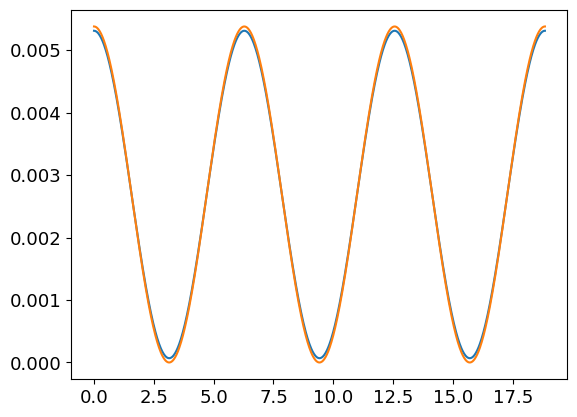

In [62]:
#Now look at the sum of the both channels with the single photon resonance removed

ySumCH1andCH3 = yCH1filtNoSinglePhoton+yCH3filtNoSinglePhoton
tSumCH1andCH3 = tCH1filtNoSinglePhoton

print(yCH3filtNoSinglePhoton[4000])

#remove the start of the trace that looks weird
#remove the first 4000 points 

IndicesRemoveStart = np.arange(0,6000,1)

ySumCH1andCH3RemoveStart = np.delete(ySumCH1andCH3, IndicesRemoveStart)
tSumCH1andCH3RemoveStart = np.delete(tSumCH1andCH3, IndicesRemoveStart)

#plt.plot(tSumCH1andCH3RemoveStart, ySumCH1andCH3RemoveStart)
print(np.mean(ySumCH1andCH3RemoveStart),'np.mean(ySumCH1andCH3RemoveStart)')
print(np.mean(ySumCH1andCH3),'np.mean(ySumCH1andCH3)')

PD1PlusD2 = BaselineAmplitudeCHSum1and3 = np.mean(ySumCH1andCH3RemoveStart)
print(PD1PlusD2)
print(BaselineAmplitudeCHSum1and3)

#We now have the average power for both channels summed together over the scan! Without the single photon resonance


gamma = 1 #guess a value of gamma such that the two plots below are well overlapped

print(PD1PlusD2,'PD1PlusD2')
print(DifferenceBetweenPeakAndTrough,'DifferenceBetweenPeakAndTrough')
print(gamma, 'gamma')
a = 4
b = -4*PD1PlusD2
c = ((DifferenceBetweenPeakAndTrough)**2)/gamma**2
#P2 = (-b+(b**2-4*a*c)**0.5)/(2*a)

#print(P2, 'This is P2, the amplitude response proportional to the power in the second interferometer arm (V)')

P2Plus = (-b+(b**2-4*a*c)**0.5)/(2*a)
P2minus = (-b-(b**2-4*a*c)**0.5)/(2*a)

print(P2Plus, 'P2Plus')
print(P2minus, 'P2minus')

P1 = 1.0*(PD1PlusD2/2)

P2 = 1.0*(PD1PlusD2/2)
#print(P1,'guessed P1 value')
#print(P2,'guessed P2 value')

#P2 = P2Plus
#P1 = PD1PlusD2-P2Plus

#P1 = PD1PlusD2-P2

print(P1, 'This is P1, the amplitude response proportional to the power in the first interferometer arm (V)')

print((P1+P2), 'P1+P2')
print((P1*P2)**0.5, 'P1*P2 square rooted')

print((P1+P2)/2+(P1*P2)**0.5, 'P1*P2 square rooted and added to P1+P2 divded by 2')

print((P1+P2)/2+DifferenceBetweenPeakAndTrough/2, 'P1*P2 square rooted and added half the difference between peak and trough')

print(DifferenceBetweenPeakAndTrough/2,'DifferenceBetweenPeakAndTrough/2')

x = np.linspace(0,6*np.pi, 1000)
y = PD1PlusD2/2 + (DifferenceBetweenPeakAndTrough/2)*np.cos(x)
z = (P1+P2)/2 + ((P1*P2)**0.5)*gamma*np.cos(x)

plt.plot(x, y)
plt.plot(x, z)

#I believe the difference between our calculated constant infront of the cos term and the measured constant infront of 
#the cos term (i.e. half the difference between a peak and trough)
#this is likely due to our interferometer polarisation not being perfect 
#this adds a cos squared term infront of the cos term that goes between 1 and 0 

#instead we guess the values for P1 and P2 such that the two photon absorption for the two peaks look the same
#our visibility is slightly lower than with our guessed P1 and P2 values as gamma is actually slightly less than 1
#despite having peaked it experimentally, it is not possible to get it exactly to 1 with perfect polarisation overlap


6399
127980
197240
0           0.004934
1           0.005271
2           0.004591
3           0.005281
4           0.005110
              ...   
15999997    0.005261
15999998    0.005281
15999999    0.005100
16000000    0.005261
16000001    0.005442
Name: Ampl, Length: 16000002, dtype: float64
[4462 4461 4460 4459 4458 4457 4456 4455 4454 4453 4452 4451 4450 4449
 4448 4447 4446 4445 4444 4443]
[[    4462     6960     9462 ... 15994412 15996911 15999412]
 [    4461     6959     9461 ... 15994411 15996910 15999411]
 [    4460     6958     9460 ... 15994410 15996909 15999410]
 ...
 [    4445     6943     9445 ... 15994395 15996894 15999395]
 [    4444     6942     9444 ... 15994394 15996893 15999394]
 [    4443     6941     9443 ... 15994393 15996892 15999393]]
(20, 6399)
2
6399 columns
20 rows
[[ 4.60520465e-04  4.60520465e-04 -2.24140465e-04 ...  2.89355233e-04
   1.18190000e-04  2.89355233e-04]
 [ 1.18190000e-04  2.89355233e-04  2.89355233e-04 ...  2.89355233e-04
   4.60520465e-04  1.

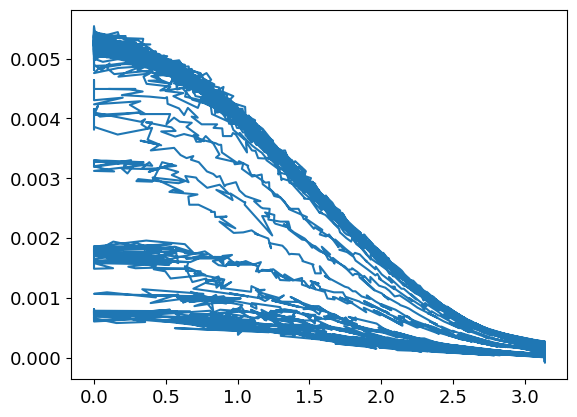

In [63]:
#Calculations of values (use previous python script to work out all the parameters...) for each point, and take averages
#over the points for the same peaks for the phase shift and absorption 

#We can work out phi, the global phase when a control pulse comes in
#by looking at the channel 1 values just before the control pulse comes in, and then taking an average over
#a few 10's of values 

HalfFullHeight = DifferenceBetweenPeakAndTrough/2

print(len(IndexCentreControlPeak))
print((IndexCH1BackGroundPoints.size))
print((20*9862))
print(yCHSum1and3)
print(IndexCH1BackGroundPoints[:, 0])
print(IndexCH1BackGroundPoints)
#print(yCHSum1and3[IndexCH1BackGroundPoints[:, i]])

print(IndexCH1BackGroundPoints.shape)
print(IndexCH1BackGroundPoints.ndim)

#convert the array of arrays into a 2D array? 

columns = IndexCH1BackGroundPoints.shape[1]
rows = IndexCH1BackGroundPoints.shape[0]

print(columns,'columns')
print(rows,'rows')

AmplitudeOfCH1BackGroundIndices  = []

for j in range(columns):
     for i in range(rows):
        yStuff = yCH1[IndexCH1BackGroundPoints[i][j]]
        AmplitudeOfCH1BackGroundIndices.append(yStuff)

AmplitudeOfCH1BackGroundIndicesnp = np.asarray(AmplitudeOfCH1BackGroundIndices)         

#finding the background amplitude before the control pulse for channel 1 at each of the points 

AmplitudeOfCHSum1and3BackGroundIndices  = []       
        
for j in range(columns):
     for i in range(rows):
        yStuff3 = yCHSum1and3[IndexCH1BackGroundPoints[i][j]]
        AmplitudeOfCHSum1and3BackGroundIndices.append(yStuff3)        

#finding the background amplitude before the control pulse for the sum of channel 1 and 2 at each of the points as 
#we found the background amplitude for channel 1 
        
AmplitudeOfCHSum1and3BackGroundIndicesnp =    np.asarray(AmplitudeOfCHSum1and3BackGroundIndices) 

TestingArrayShape  = []

for j in range(columns):
     for i in range(rows):
        yStuff2 = IndexCH1BackGroundPoints[i][j]
        TestingArrayShape.append(yStuff2)

#print(TestingArrayShape, 'This is a 1d row that is made up of the elements in each column one after another from top to bottom elements')

#we reshape the output from the loop, which is a 1D array into the desired columns and rows 

TestingArrayShapeReshaped = np.reshape(TestingArrayShape, (-1, IndexCH1BackGroundPoints.shape[0]))

#the reshaped array is now the correct dimensions, points in a row are from the same control pulse
#and points down a column are from a different control pulse at the same spacing from the centre of the control pulse
#if we want it in the same form as the original matrix we must transpose it to switch the columns and rows around

TestingArrayShapeReshapedT = np.transpose(TestingArrayShapeReshaped)

#by transposing the matrix we now have the same format for the values matrix as for the indices matrix previously! 
#we should then be able to read columns and rows and do useful things with them...

#print(TestingArrayShapeReshapedT, 'TestingArrayShapeReshapedT')


#currently getting a 1D array as the output, need to change this into a 2D array output...

AmplitudeOfCH1BackGroundIndicesnp2d = np.reshape(AmplitudeOfCH1BackGroundIndicesnp, (-1, IndexCH1BackGroundPoints.shape[0]))

AmplitudeOfCH1BackGroundIndicesnp2dT = np.transpose(AmplitudeOfCH1BackGroundIndicesnp2d) #transpose of matrix

print(AmplitudeOfCH1BackGroundIndicesnp2dT, 'AmplitudeOfCH1BackGroundIndicesnp2dT')

AverageCH1Background = AmplitudeOfCH1BackGroundIndicesnp2dT.mean(axis=0) #find the mean of each column 

#AverageCH1Background gives us the average background amplitude before the control field turns on
#Calculating the same for the summed of channel 1 and channel 3 so that we can work out phase shift and loss 
#at the single photon resonance which has a lower background count due to the single photon absorption

AmplitudeOfCHSum1and3BackGroundIndicesnp2d = np.reshape(AmplitudeOfCHSum1and3BackGroundIndicesnp, (-1, IndexCH1BackGroundPoints.shape[0]))

AmplitudeOfCHSum1and3BackGroundIndicesnp2dT = np.transpose(AmplitudeOfCHSum1and3BackGroundIndicesnp2d) #transpose of matrix

print(AmplitudeOfCHSum1and3BackGroundIndicesnp2dT, 'AmplitudeOfCHSum1and3BackGroundIndicesnp2dT')

AverageCHSum1and3Background = AmplitudeOfCHSum1and3BackGroundIndicesnp2dT.mean(axis=0) #find the mean of each column 


#Next we calculate the phase 

ResidualTerm = AverageCHSum1and3Background/2  #constant off set/middle of interferometer trace (P1+P2)/2

print(np.min(AverageCH1Background))

print(ResidualTerm)
print(ConstantInfrontOfCos)
print(((AverageCH1Background-ResidualTerm)/(ConstantInfrontOfCos)), 'term in arccos')


print(max(AverageCHSum1and3Background),'max(AverageCHSum1and3Background)')

ConstantInfrontOfCosAdjustedForAbsorption = ((AverageCHSum1and3Background/max(AverageCHSum1and3Background))*ConstantInfrontOfCos)

print(PD1PlusD2, 'average of sum of CH1 and CH3 with single photon absorption removed')
print(max(AverageCHSum1and3Background), 'maximum CH1 and CH3 background')

print(ConstantInfrontOfCosAdjustedForAbsorption, 'ConstantInfrontOfCosAdjustedForAbsorption')

print(min(ConstantInfrontOfCosAdjustedForAbsorption),'minimum ConstantInfrontOfCosAdjustedForAbsorption')
print(max(ConstantInfrontOfCosAdjustedForAbsorption),'maximum ConstantInfrontOfCosAdjustedForAbsorption')

TermInCosine = (1*(AverageCH1Background-ResidualTerm))/(ConstantInfrontOfCosAdjustedForAbsorption)
#scaling factor to reduce the maximum and minimum of the term so that very few of the points go over 1 or below -1 

print(TermInCosine[np.where( TermInCosine > 1.0 )],'where the term in cosine is greater than 1')
np.where(TermInCosine>1.0,  print(TermInCosine, 'term in cosine with np where'), TermInCosine)

itemindex = np.where(TermInCosine > 1.0)
print(itemindex)

#replacing values over 1 as 1 and below -1 as -1

TermInCosine2 = np.where(TermInCosine>1.0,  1, TermInCosine)  #setting values over 1 as 1
TermInCosine3 = np.where(TermInCosine2<-1.0,  -1, TermInCosine2) #setting values below -1 as -1

#TermInCosine3 = TermInCosine3
TermInCosine = TermInCosine3

print(np.max(TermInCosine3))
print(np.min(TermInCosine3))

PhiNearControl = np.arccos(TermInCosine3) #array of estimated global phases for each control pulse time 

print(PhiNearControl.ndim)
print(PhiNearControl.shape)

PhiNearControl1 = PhiNearControl

print(np.argwhere(np.isnan(PhiNearControl1)), 'PhiNearControl1 is NaN')

print(np.count_nonzero(np.isnan(PhiNearControl)), 'number of indices where phi is NaN')

print(max(PhiNearControl))

plt.plot(PhiNearControl,AverageCH1Background)

#we need to scale the constant infront of cos in order to account for single photon absorption
#currently our channel 1 background is measured before each control and so will get smaller
#as we go towards single photon resonance
#our residual term is half the sum of channel 1 and channel 3 and will also get smaller as we go towards
#the single photon resonance
#we need an array of scaling factors for constant infront of cos
#the best way to accomplish this will be to divide the maximum sum of channel 1 and channel 3 
#by the sum of channel 1 and channel 3 
#as P1 and P2 will be in the same ratio of amplitudes and the polarisation will be the same, we are just scaling down
#both P1 and P2 by the same amount, so both would be times by some e^-b term which would be square rooted.
#as it is the same term for each, we times the two e^-b terms square rooted together to get e^-b
#where this e^-b is just a fraction of the light absorbed by the single photon resonance

In [64]:
#Calculating the relative phase by working out the powers of both channels away from the effect of the control pulse 

#Need to take the CH1, CH3 and CH1 + CH3 indices arrays and convert into y values for the first and second peaks 

columns = IndexCHSumFirstPeak.shape[1]
rows = IndexCHSumFirstPeak.shape[0]

print(columns,'columns')
print(rows,'rows')

#Channel 1 + 3 peak 1 

AmplitudeOfCHSum1and3Peak1  = []

for j in range(columns):
     for i in range(rows):
        yStuffCHSumPeak1 = yCHSum1and3[IndexCHSumFirstPeak[i][j]]
        AmplitudeOfCHSum1and3Peak1.append(yStuffCHSumPeak1)        

AmplitudeOfCHSum1and3Peak12d = np.reshape(AmplitudeOfCHSum1and3Peak1, (-1, IndexCHSumFirstPeak.shape[0]))

AmplitudeOfCHSum1and3Peak12dT = np.transpose(AmplitudeOfCHSum1and3Peak12d) #transpose of matrix

print(AmplitudeOfCHSum1and3Peak12dT, 'AmplitudeOfCHSum1and3Peak12dT')        

#Channel 1 + 3 peak 2 

AmplitudeOfCHSum1and3Peak2  = []        
        
for j in range(columns):
     for i in range(rows):
        yStuffCHSumPeak2 = yCHSum1and3[IndexCHSumSecondPeak[i][j]]
        AmplitudeOfCHSum1and3Peak2.append(yStuffCHSumPeak2)          

AmplitudeOfCHSum1and3Peak22d = np.reshape(AmplitudeOfCHSum1and3Peak2, (-1, IndexCHSumSecondPeak.shape[0]))

AmplitudeOfCHSum1and3Peak22dT = np.transpose(AmplitudeOfCHSum1and3Peak22d) #transpose of matrix

print(AmplitudeOfCHSum1and3Peak22dT, 'AmplitudeOfCHSum1and3Peak22dT')          
        
#Channel 3 peak 1 
    
AmplitudeOfCH3Peak1  = []         
        
for j in range(columns):
     for i in range(rows):
        yStuffCH3Peak1 = yCH3[IndexCH3FirstPeak[i][j]]
        AmplitudeOfCH3Peak1.append(yStuffCH3Peak1)    

AmplitudeOfCH3Peak12d = np.reshape(AmplitudeOfCH3Peak1, (-1, IndexCH3FirstPeak.shape[0]))

AmplitudeOfCH3Peak12dT = np.transpose(AmplitudeOfCH3Peak12d) #transpose of matrix

print(AmplitudeOfCH3Peak12dT, 'AmplitudeOfCH3Peak12dT')               

#Channel 1 peak 1 

AmplitudeOfCH1Peak1  = []        
        
for j in range(columns):
     for i in range(rows):
        yStuffCH1Peak1 = yCH1[IndexCH1FirstPeak[i][j]]
        AmplitudeOfCH1Peak1.append(yStuffCH1Peak1)           

AmplitudeOfCH1Peak12d = np.reshape(AmplitudeOfCH1Peak1, (-1, IndexCH1FirstPeak.shape[0]))

AmplitudeOfCH1Peak12dT = np.transpose(AmplitudeOfCH1Peak12d) #transpose of matrix

print(AmplitudeOfCH1Peak12dT, 'AmplitudeOfCH1Peak12dT')     
        
        
#Channel 3 peak 2         
        
AmplitudeOfCH3Peak2 = []        
        
for j in range(columns):
     for i in range(rows):
        yStuffCH3Peak2 = yCH3[IndexCH3SecondPeak[i][j]]
        AmplitudeOfCH3Peak2.append(yStuffCH3Peak2)    

AmplitudeOfCH3Peak22d = np.reshape(AmplitudeOfCH3Peak2, (-1, IndexCH3SecondPeak.shape[0]))

AmplitudeOfCH3Peak22dT = np.transpose(AmplitudeOfCH3Peak22d) #transpose of matrix

print(AmplitudeOfCH3Peak22dT, 'AmplitudeOfCH3Peak22dT')           
        
#Channel 1 peak 2         
        
AmplitudeOfCH1Peak2 = []        
        
for j in range(columns):
     for i in range(rows):
        yStuffCH1Peak2 = yCH1[IndexCH1SecondPeak[i][j]]
        AmplitudeOfCH1Peak2.append(yStuffCH1Peak2)    
        
AmplitudeOfCH1Peak22d = np.reshape(AmplitudeOfCH1Peak2, (-1, IndexCH1SecondPeak.shape[0]))

AmplitudeOfCH1Peak22dT = np.transpose(AmplitudeOfCH1Peak22d) #transpose of matrix

print(AmplitudeOfCH1Peak22dT, 'AmplitudeOfCH1Peak22dT')          


#should have all the values for the peaks for the 3 channels now in the arrays
#we should double check that these values are correct by looking at some traces up close
#can set the limits as the the time of a control pulse +/- a bit of time to zoom in on part of a trace
#then we should try calculating the loss and phase shift for each set of points in the arrays
#hten take an average of the columns 

6399 columns
5 rows
[[0.00644844 0.00476238 0.00476238 ... 0.002821   0.00299217 0.00332426]
 [0.00527588 0.00492842 0.00528099 ... 0.00314286 0.00247355 0.00263449]
 [0.0049489  0.00544704 0.00528611 ... 0.00213635 0.00247355 0.00280053]
 [0.00562844 0.00561821 0.00596054 ... 0.00365123 0.00230239 0.00314798]
 [0.00528099 0.00527588 0.00477262 ... 0.00247868 0.00264472 0.00213635]] AmplitudeOfCHSum1and3Peak12dT
[[0.00559773 0.00559773 0.00492331 ... 0.00280053 0.00330891 0.00365123]
 [0.00560286 0.00559261 0.00542656 ... 0.00331914 0.00348518 0.00332426]
 [0.00509959 0.00510472 0.00559261 ... 0.00298193 0.00315309 0.00297682]
 [0.00560286 0.00544704 0.00461169 ... 0.00264984 0.00283123 0.00331402]
 [0.00492842 0.00592983 0.00442517 ... 0.00315309 0.00281588 0.00281588]] AmplitudeOfCHSum1and3Peak22dT
[[0.00564559 0.00481536 0.00481536 ... 0.00116233 0.00116233 0.00149442]
 [0.00481536 0.0049814  0.00464931 ... 0.00182651 0.00132837 0.00166047]
 [0.00431722 0.00481536 0.00448326 ... 0.0

In [65]:
#Calculate absorption for each point, and then take an average and standard deviation for each column 
#(values for same control pulse)

#we adjust P1 and P2 to account for absorption

print(AverageCHSum1and3Background,'AverageCHSum1and3Background')

print(PD1PlusD2,'PD1PlusD2')
#P1Adjusted = (AverageCHSum1and3Background/max(AverageCHSum1and3Background))*P1

#P2Adjusted = (AverageCHSum1and3Background/max(AverageCHSum1and3Background))*P2

columns = IndexCHSumFirstPeak.shape[1]
rows = IndexCHSumFirstPeak.shape[0]

#MeanAverageCHSum1and3Background = np.mean(AverageCHSum1and3Background)
#print(MeanAverageCHSum1and3Background)

#adjusting the powers by the ratio of the background power before a control pulse by the average background power away from the single photon absorption
#this scales the powers to account for variations and single photon absorption

P1Adjusted = (AverageCHSum1and3Background/PD1PlusD2)*P1
#P1Adjusted = (AverageCHSum1and3Background/AverageCHSum1and3Background)*P1

P2Adjusted = (AverageCHSum1and3Background/PD1PlusD2)*P2
#P2Adjusted = (AverageCHSum1and3Background/AverageCHSum1and3Background)*P2

print(AverageCHSum1and3Background/PD1PlusD2, 'AverageCHSum1and3Background/PD1MAX')

#forming a 2d array of powers

P1Adjusted2d = np.array([[P1Adjusted],[P1Adjusted],[P1Adjusted],[P1Adjusted],[P1Adjusted]])
P2Adjusted2d = np.array([[P2Adjusted],[P2Adjusted],[P2Adjusted],[P2Adjusted],[P2Adjusted]])

#P1Adjusted2d = np.array([[P1Adjusted],[P1Adjusted],[P1Adjusted],[P1Adjusted],[P1Adjusted],[P1Adjusted],[P1Adjusted],[P1Adjusted],[P1Adjusted],[P1Adjusted],[P1Adjusted]])
#P2Adjusted2d = np.array([[P2Adjusted],[P2Adjusted],[P2Adjusted],[P2Adjusted],[P2Adjusted],[P2Adjusted],[P2Adjusted],[P2Adjusted],[P2Adjusted],[P2Adjusted],[P2Adjusted]])

#reshaping the 2d array into the correct shape

P1Adjusted2dReshape =  P1Adjusted2d.reshape(rows,columns)
P2Adjusted2dReshape =  P2Adjusted2d.reshape(rows,columns)

P2Adjusted = P1Adjusted2dReshape
P1Adjusted = P2Adjusted2dReshape

#swapping P1 and P2, P2 is the bigger value and so should correspond to loss for the first peak, and P1 should have
#the loss term for the second peak 

print(P1Adjusted,'P1Adjusted2d')
print(P2Adjusted,'P2Adjusted2d')

#calculating the absorption coefficient alpha, and the transmission e^-2a

AlphaFirstPeak = -0.5*np.log((AmplitudeOfCHSum1and3Peak12dT-P2Adjusted)/P1Adjusted)
print(AlphaFirstPeak, 'AlphaFirstPeak') 
        
AlphaFirstPeakMean = AlphaFirstPeak.mean(axis=0) #find the mean of each column 
AlphaFirstPeakTstd = AlphaFirstPeak.std(axis=0) #find the mean of each column    
    
TransmissionRatioFirst = (AmplitudeOfCHSum1and3Peak12dT-P2Adjusted)/P1Adjusted

print(np.argwhere(np.isnan(TransmissionRatioFirst)), 'TransmissionRatioFirst is NaN')

TransmissionRatioFirstMean = TransmissionRatioFirst.mean(axis=0) #find the mean of each column 
TransmissionRatioFirststd = TransmissionRatioFirst.std(axis=0) #find the mean of each column

print(TransmissionRatioFirst, 'TransmissionRatioFirst')              
        
#print(AlphaFirstPeakstd, 'AlphaFirstPeakstd')

#print(AlphaFirstPeakMean,'AlphaFirstPeakMean')

#It looks like the loop and just simple calculation are identical if all our values are 2d matrices of the same size!
#it is just doing the maths operation element by element by default! 

AlphaSecondPeak = -0.5*np.log((AmplitudeOfCHSum1and3Peak22dT-P1Adjusted)/P2Adjusted)

print(AlphaSecondPeak[:,0],'AlphaSecondPeak')
#print(AlphaSecondPeak.ndim,'AlphaSecondPeak.ndim')
#print(AlphaSecondPeak.shape,'AlphaSecondPeak.shape')

TransmissionRatioSecond = (AmplitudeOfCHSum1and3Peak22dT-P1Adjusted)/P2Adjusted
#TransmissionRatioSecond = (AmplitudeOfCHSum1and3Peak22dT-P2Adjusted)/P1Adjusted

TransmissionRatioSecondMean = TransmissionRatioSecond.mean(axis=0) #find the mean of each column 
TransmissionRatioSecondstd = TransmissionRatioSecond.std(axis=0) #find the mean of each column

print(TransmissionRatioFirststd, 'TransmissionRatioFirststd')
print(TransmissionRatioFirstMean,'TransmissionRatioFirstMean')

print(TransmissionRatioSecondstd, 'TransmissionRatioSecondstd')
print(TransmissionRatioSecondMean,'TransmissionRatioSecondMean')

#print(AlphaSecondPeak, 'AlphaSecondPeak')

AlphaSecondPeakMean = AlphaSecondPeak.mean(axis=0) #find the mean of each column 
AlphaSecondPeakstd = AlphaSecondPeak.std(axis=0) #find the mean of each column 

#print(AlphaSecondPeakstd, 'AlphaSecondPeakstd')

#print(AlphaSecondPeakMean.shape)
#print(AlphaSecondPeakMean.ndim)

#Deleting the single photon resonance from the means 

SpacingBetweenControlPeaksIndices = (peaksControl[0]+peaksControl[-1])/len(peaksControl)

print(len(peaksControl))
print(SpacingBetweenControlPeaksIndices)
print(IndicesThroughPeak)
IndicesThroughPeakInTermsOfControlPeaks = ((IndicesThroughPeak)/SpacingBetweenControlPeaksIndices).astype(int)
print(IndicesThroughPeakInTermsOfControlPeaks)
IndicesThroughPeakInTermsOfControlPeaks2 = np.arange(IndicesThroughPeakInTermsOfControlPeaks[0],len(peaksControl)-1,1)
print(IndicesThroughPeakInTermsOfControlPeaks2)
AlphaSecondPeakMeanNoSinglePhoton = np.delete(AlphaSecondPeakMean, IndicesThroughPeakInTermsOfControlPeaks2)
tCH1npNoSinglePhoton = np.delete(tCH1np, IndicesThroughPeakInTermsOfControlPeaks2)



[0.00527829 0.0054018  0.0053442  ... 0.0051678  0.00515069 0.00523653] AverageCHSum1and3Background
0.005377460665303434 PD1PlusD2
[0.98155872 1.00452699 0.99381459 ... 0.96101165 0.95782863 0.97379152] AverageCHSum1and3Background/PD1MAX
[[0.00263915 0.0027009  0.0026721  ... 0.0025839  0.00257534 0.00261826]
 [0.00263915 0.0027009  0.0026721  ... 0.0025839  0.00257534 0.00261826]
 [0.00263915 0.0027009  0.0026721  ... 0.0025839  0.00257534 0.00261826]
 [0.00263915 0.0027009  0.0026721  ... 0.0025839  0.00257534 0.00261826]
 [0.00263915 0.0027009  0.0026721  ... 0.0025839  0.00257534 0.00261826]] P1Adjusted2d
[[0.00263915 0.0027009  0.0026721  ... 0.0025839  0.00257534 0.00261826]
 [0.00263915 0.0027009  0.0026721  ... 0.0025839  0.00257534 0.00261826]
 [0.00263915 0.0027009  0.0026721  ... 0.0025839  0.00257534 0.00261826]
 [0.00263915 0.0027009  0.0026721  ... 0.0025839  0.00257534 0.00261826]
 [0.00263915 0.0027009  0.0026721  ... 0.0025839  0.00257534 0.00261826]] P2Adjusted2d
[[-1

C:\Users\willd\AppData\Local\Temp\ipykernel_1408\3492603996.py:54: RuntimeWarning: invalid value encountered in log
  AlphaFirstPeak = -0.5*np.log((AmplitudeOfCHSum1and3Peak12dT-P2Adjusted)/P1Adjusted)
C:\Users\willd\AppData\Local\Temp\ipykernel_1408\3492603996.py:76: RuntimeWarning: invalid value encountered in log
  AlphaSecondPeak = -0.5*np.log((AmplitudeOfCHSum1and3Peak22dT-P1Adjusted)/P2Adjusted)


In [66]:
#removing the single photon resonance data

TransmissionRatioFirstMeanNoSinglePhoton = np.delete(TransmissionRatioFirstMean, IndicesThroughPeakInTermsOfControlPeaks2)
TransmissionRatioSecondMeanNoSinglePhoton = np.delete(TransmissionRatioSecondMean, IndicesThroughPeakInTermsOfControlPeaks2)

AlphaFirstPeakMeanNoSinglePhoton = np.delete(AlphaFirstPeakMean, IndicesThroughPeakInTermsOfControlPeaks2)
tCH3npNoSinglePhoton = np.delete(tCH3np, IndicesThroughPeakInTermsOfControlPeaks2)

print(len(TransmissionRatioFirstMean))


6399


In [67]:
#Calculate change in phase due to control for each point, and then take an average and standard deviation for each column 
#(values for same control pulse)

#creating a 2d matrix of the global phase phi before each control pulse 

columns = IndexCHSumFirstPeak.shape[1]
rows = IndexCHSumFirstPeak.shape[0]

PhiNearControl2d = np.array([[PhiNearControl],[PhiNearControl],[PhiNearControl],[PhiNearControl],[PhiNearControl]])

PhiNearControl2dReshape = PhiNearControl2d.reshape(rows,columns)

PhiNearControl = PhiNearControl2dReshape

PhiNearControlMean = PhiNearControl.mean(axis=0)

print(PhiNearControl)

#For first peak re-calculating

TermInArcCos = (AmplitudeOfCH1Peak12dT-(P2Adjusted+P1Adjusted*TransmissionRatioFirst)/2)/(ConstantInfrontOfCos*TransmissionRatioFirst**0.5)

ArcCos = np.arccos(TermInArcCos)

print(ArcCos,'ArcCos')

print(np.count_nonzero(np.isnan(ArcCos)), 'number of indices where delta phi 1 is NaN')

print(TermInArcCos.shape,'TermInArcCos.shape')

ArcCosnan = np.nanmean(ArcCos,axis=0)
print(ArcCosnan -PhiNearControlMean)

DeltaPhiCFirstPeak3 = ArcCosnan -PhiNearControlMean
DeltaPhiCFirstPeak3Mean = DeltaPhiCFirstPeak3

TermInArcCosMean = TermInArcCos.mean(axis=0)

#Second peak re-calculating

TermInArcCos2nd = (AmplitudeOfCH1Peak22dT-(P1Adjusted+P2Adjusted*TransmissionRatioSecond)/2)/(ConstantInfrontOfCos*TransmissionRatioSecond**0.5)

ArcCos2nd = np.arccos(TermInArcCos2nd)

print(np.count_nonzero(np.isnan(ArcCos2nd)), 'number of indices where delta phi 2 is NaN')

ArcCos2ndnan = np.nanmean(ArcCos2nd,axis=0)
print(ArcCos2ndnan -PhiNearControlMean)

DeltaPhiCFirstPeak2nd3 = ArcCos2ndnan -PhiNearControlMean
DeltaPhiCFirstPeak2nd3Mean = DeltaPhiCFirstPeak2nd3

#removing single photon resonance

DeltaPhiCFirstPeak3Mean = np.delete(DeltaPhiCFirstPeak3Mean, IndicesThroughPeakInTermsOfControlPeaks2)
DeltaPhiCFirstPeak2nd3Mean = np.delete(DeltaPhiCFirstPeak2nd3Mean, IndicesThroughPeakInTermsOfControlPeaks2)

print((P1Adjusted*P2Adjusted)**0.5,'(P1Adjusted*P2Adjusted)**0.5')
print((TransmissionRatioFirst**0.5,'TransmissionRatioFirst**0.5'))

TimeToFrequencyAllData = (tCH1np-CentreTimeSinglePhotonResonance)*TimeToFrequencyFactor

[[3.06438784 3.14159265 3.14159265 ... 3.14159265 3.14159265 3.11964511]
 [3.06438784 3.14159265 3.14159265 ... 3.14159265 3.14159265 3.11964511]
 [3.06438784 3.14159265 3.14159265 ... 3.14159265 3.14159265 3.11964511]
 [3.06438784 3.14159265 3.14159265 ... 3.14159265 3.14159265 3.11964511]
 [3.06438784 3.14159265 3.14159265 ... 3.14159265 3.14159265 3.11964511]]
[[2.64250195        nan 2.42643862 ... 1.68971144 1.91018844 2.10109241]
 [2.44355431 2.44993296 2.36007389 ... 2.08318536        nan        nan]
 [2.14400698 2.3847753  2.18711012 ...        nan        nan 1.44424924]
 [2.46983641 2.61103851 2.75403972 ... 1.87804741        nan 2.10495945]
 [2.68357922 2.73398701 2.92395162 ...        nan 1.58477587        nan]] ArcCos
5598 number of indices where delta phi 1 is NaN
(5, 6399) TermInArcCos.shape
[-0.58769206 -0.59665921 -0.61126986 ... -1.25794459 -1.3941105
 -1.23621141]
8752 number of indices where delta phi 2 is NaN
[-0.27763376 -0.33453448 -0.59758204 ... -1.54382677 -1.70

C:\Users\willd\AppData\Local\Temp\ipykernel_1408\4057937779.py:21: RuntimeWarning: invalid value encountered in sqrt
  TermInArcCos = (AmplitudeOfCH1Peak12dT-(P2Adjusted+P1Adjusted*TransmissionRatioFirst)/2)/(ConstantInfrontOfCos*TransmissionRatioFirst**0.5)
C:\Users\willd\AppData\Local\Temp\ipykernel_1408\4057937779.py:37: RuntimeWarning: invalid value encountered in arccos
  ArcCos = np.arccos(TermInArcCos)
C:\Users\willd\AppData\Local\Temp\ipykernel_1408\4057937779.py:73: RuntimeWarning: Mean of empty slice
  ArcCosnan = np.nanmean(ArcCos,axis=0)
C:\Users\willd\AppData\Local\Temp\ipykernel_1408\4057937779.py:87: RuntimeWarning: invalid value encountered in sqrt
  TermInArcCos2nd = (AmplitudeOfCH1Peak22dT-(P1Adjusted+P2Adjusted*TransmissionRatioSecond)/2)/(ConstantInfrontOfCos*TransmissionRatioSecond**0.5)
C:\Users\willd\AppData\Local\Temp\ipykernel_1408\4057937779.py:97: RuntimeWarning: invalid value encountered in arccos
  ArcCos2nd = np.arccos(TermInArcCos2nd)
C:\Users\willd\AppDa

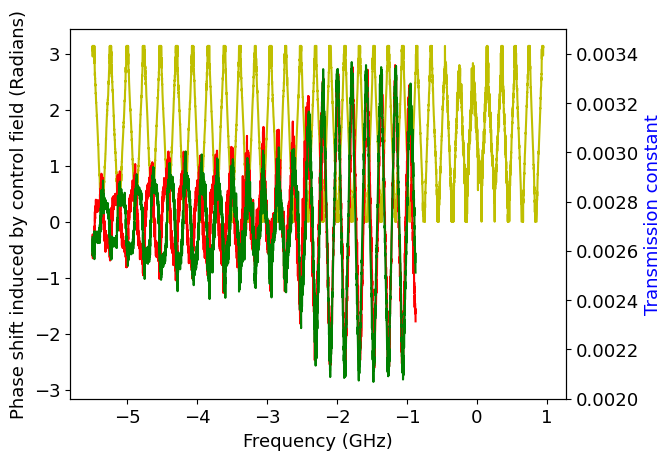

      MeanAmplitudeOfCHSum1and3Peak12dT          Time
0                                   NaN           NaN
1                                   NaN           NaN
2                                   NaN           NaN
3                                   NaN           NaN
4                                   NaN           NaN
...                                 ...           ...
6394                           0.002679  9.329763e+08
6395                           0.002677  9.339845e+08
6396                           0.002680  9.349928e+08
6397                           0.002685  9.360010e+08
6398                           0.002703  9.370093e+08

[6399 rows x 2 columns]
      MeanAmplitudeOfCHSum1and3Peak22dT          Time
0                                   NaN           NaN
1                                   NaN           NaN
2                                   NaN           NaN
3                                   NaN           NaN
4                                   NaN           NaN
...

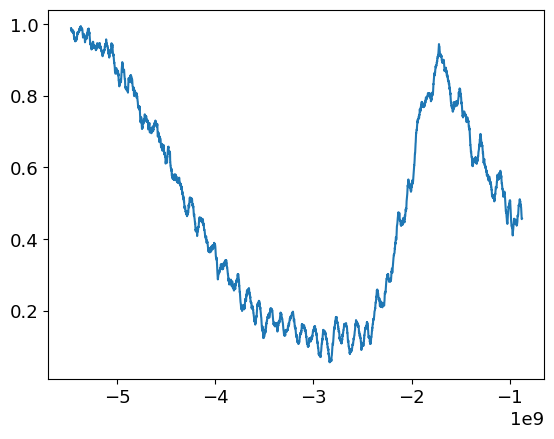

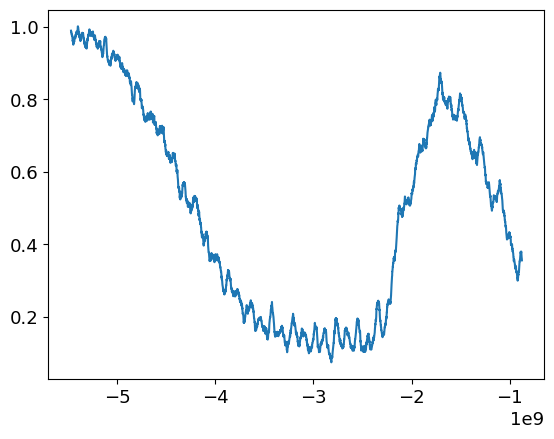

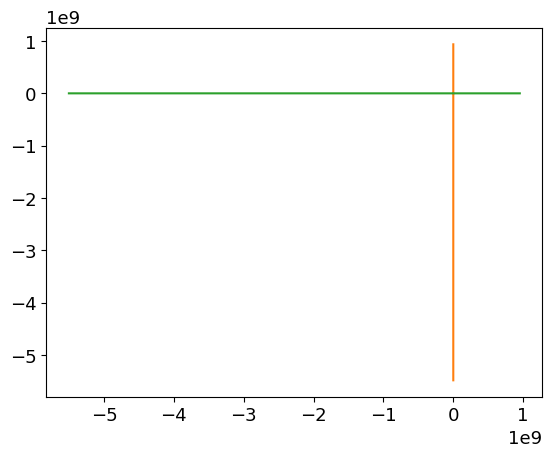

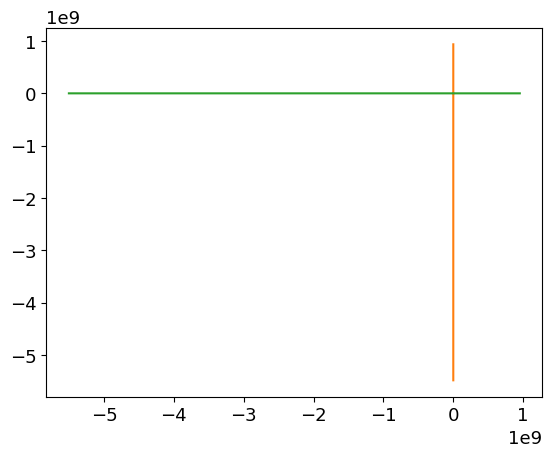

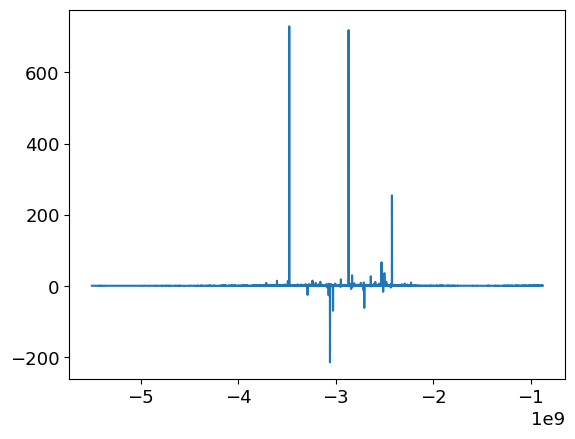

In [69]:
#Plot out the average phase shift and absorption/transmitted power for each signal detuning value for each control pulse
#could use the standard deviations for error bars? 

IndexCentreControlPeakNoSinglePhoton = np.delete(IndexCentreControlPeak, IndicesThroughPeakInTermsOfControlPeaks2) 

TimeToFrequency = (tCH1np[IndexCentreControlPeak]-CentreTimeSinglePhotonResonance)*TimeToFrequencyFactor
TimeToFrequencyNoSinglePhoton = (tCH1npNoSinglePhoton[IndexCentreControlPeakNoSinglePhoton]-CentreTimeSinglePhotonResonance)*TimeToFrequencyFactor

TimeToFrequencyAllData = (tCH1np-CentreTimeSinglePhotonResonance)*TimeToFrequencyFactor

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()

#P1 and P2 look sensible 

MeanAmplitudeOfCHSum1and3Peak12dT =  AmplitudeOfCHSum1and3Peak12dT.mean(axis=0)
MeanAmplitudeOfCHSum1and3Peak22dT =  AmplitudeOfCHSum1and3Peak22dT.mean(axis=0)

ax1.plot(TimeToFrequency*10**-9 , PhiNearControl1, 'y')


ax1.plot(TimeToFrequencyNoSinglePhoton*10**-9 , DeltaPhiCFirstPeak3Mean, 'r')
ax1.plot(TimeToFrequencyNoSinglePhoton*10**-9 , DeltaPhiCFirstPeak2nd3Mean, 'g') 

ax1.set_xlabel("Frequency (GHz)")

ax1.set_ylabel("Phase shift induced by control field (Radians)")
ax2.set_ylabel('Transmission constant', color='b')

plt.savefig('Spectra of phase changes and transmission.png', dpi=400)
#plt.xlim([-7, -1])
plt.ylim([0.002, 0.0035])
plt.show()

#the oscillations in the induced phase shift seem to be exactly at the same frequency as the
#oscillations in the global phase due to the laser scanning...

#check if any of the terms in the arccos are oscillating?

#looks like the only oscillating term is AmplitudeOfCH1Peak12dT which is meant to be oscillating...

df = pd.DataFrame(TransmissionRatioFirstMeanNoSinglePhoton, TimeToFrequencyNoSinglePhoton)
df_mva = df.rolling(30).mean()  # moving average with a window size of 100
df2 = pd.DataFrame(TransmissionRatioSecondMeanNoSinglePhoton, TimeToFrequencyNoSinglePhoton)
df_mva2 = df2.rolling(30).mean()  # moving average with a window size of 100

df_mva.plot(legend = False);
df_mva2.plot(legend = False);

df3time = pd.DataFrame({"Time": TimeToFrequency})
df3T = pd.DataFrame({"MeanAmplitudeOfCHSum1and3Peak12dT": MeanAmplitudeOfCHSum1and3Peak12dT})

df3 = pd.concat([df3T, df3time], axis=1)

#print(df3)

df4time = pd.DataFrame({"Time": TimeToFrequency})
df4T = pd.DataFrame({"MeanAmplitudeOfCHSum1and3Peak22dT": MeanAmplitudeOfCHSum1and3Peak22dT})

df4 = pd.concat([df4T, df4time], axis=1)

#print(df4)

df_mva3 = df3.rolling(30).mean()  # moving average with a window size of 100
df_mva4 = df4.rolling(30).mean()  # moving average with a window size of 100

print(df_mva3)
print(df_mva4)

df_mva3.plot(legend = False);
plt.plot(TimeToFrequencyAllData, yCHSum1and3filt)
#The trace for the first peaks look like it is seeing the effect of the control field


df_mva4.plot(legend = False);
plt.plot(TimeToFrequencyAllData, yCHSum1and3filt)

df5 = pd.DataFrame(TransmissionRatioFirstMeanNoSinglePhoton/TransmissionRatioSecondMeanNoSinglePhoton, TimeToFrequencyNoSinglePhoton)
df5.plot(legend = False);

#also need to investigate the oscillating behaviour of the phase shift due to the control 

#I think something is wrong with our arccos calculation, I believe the oscillations from the arccos and the 
#phase of the scanning laser should be cancelling out...

#need to guess the ratio of the powers such that the transmission ratios match for both peaks

0.49071431512408786 MeanTransmissionRatioFirstMeanNoSinglePhoton
0.4863000865392648 MeanTransmissionRatioSecondMeanNoSinglePhoton
1.426856044200849
[1.09027108 0.92764809 0.95072418 ... 0.43931376 0.51137788 0.51540988] TransmissionRatioFirstMeanNoSinglePhoton
-0.08720775576134747
-0.06970270532766829


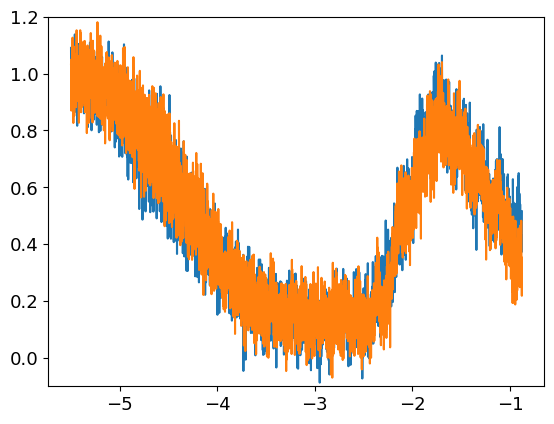

In [70]:
#guessing the P1 and P2 values and trying to match up the two photon absorption from both peaks 

plt.plot(TimeToFrequencyNoSinglePhoton*10**-9, (TransmissionRatioFirstMeanNoSinglePhoton))
plt.plot(TimeToFrequencyNoSinglePhoton*10**-9, (TransmissionRatioSecondMeanNoSinglePhoton))

plt.ylim([-0.1, 1.2])
#plt.xlim([-6, -1])

MeanTransmissionRatioFirstMeanNoSinglePhoton = np.mean(TransmissionRatioFirstMeanNoSinglePhoton)
print(MeanTransmissionRatioFirstMeanNoSinglePhoton,'MeanTransmissionRatioFirstMeanNoSinglePhoton')

MeanTransmissionRatioSecondMeanNoSinglePhoton = np.mean(TransmissionRatioSecondMeanNoSinglePhoton)
print(MeanTransmissionRatioSecondMeanNoSinglePhoton,'MeanTransmissionRatioSecondMeanNoSinglePhoton')

RatioOfPeakTransmissions = TransmissionRatioFirstMeanNoSinglePhoton/TransmissionRatioSecondMeanNoSinglePhoton

MeanRatioOfPeakTransmissions = np.mean(RatioOfPeakTransmissions)
print(MeanRatioOfPeakTransmissions)

print(TransmissionRatioFirstMeanNoSinglePhoton,'TransmissionRatioFirstMeanNoSinglePhoton')

print(TransmissionRatioFirstMeanNoSinglePhoton.min())
print(TransmissionRatioSecondMeanNoSinglePhoton.min())

#trying to choose values of P1 and P2 such that 

-0.0001515793800176
0.0002127001796016


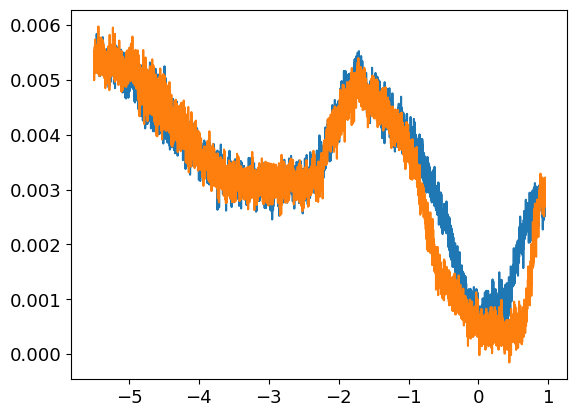

In [71]:
#plotting the sum of the two channels when the control is on over the entire scan

plt.plot(TimeToFrequency*10**-9, MeanAmplitudeOfCHSum1and3Peak12dT)
plt.plot(TimeToFrequency*10**-9, MeanAmplitudeOfCHSum1and3Peak22dT)

print(MeanAmplitudeOfCHSum1and3Peak22dT.min())
print(MeanAmplitudeOfCHSum1and3Peak12dT.min())

[   5  127  250  387  480  606  718  849  950 1077 1181 1293 1414 1541
 1634 1766 1856 1969 2091 2192 2309 2426 2641 2728 2842 2945 3065 3154
 3275 3378 3479 3582 3694 3781 3904 3999 4106 4190 4294 4394 4496] peaksDeltaPhiCFirst
[  27  149  267  388  502  627  740  862  973 1094 1207 1321 1436 1550
 1661 1768 1885 1991 2079 2198 2317 2420 2540 2643 2747 2854 2960 3069
 3166 3273 3373 3480 3571 3678 3778 3881 3986 4096 4196 4307 4406 4513] peaksDeltaPhiCSecond
             A         B             C
0     0.587692  0.277634 -5.499142e+09
1     0.596659  0.334534 -5.498135e+09
2     0.611270  0.597582 -5.497126e+09
3     0.227870  0.369319 -5.496118e+09
4     0.639080  0.361589 -5.495109e+09
...        ...       ...           ...
6394       NaN       NaN  9.475961e+08
6395       NaN       NaN  9.486039e+08
6396       NaN       NaN  9.496126e+08
6397       NaN       NaN  9.506204e+08
6398       NaN       NaN  9.516291e+08

[6399 rows x 3 columns]


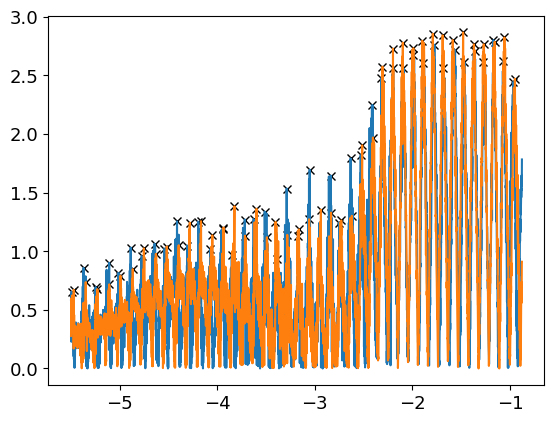

In [74]:
#calculating an average of the phase shift and finding the peaks of the modulus of the phase shift

ArcCosMean =  ArcCosnan
ArcCos2ndMean = ArcCos2ndnan

ModDeltaPhiCFirstPeakMean = (DeltaPhiCFirstPeak3Mean**2)**0.5
ModDeltaPhiCSecondPeakMean =  (DeltaPhiCFirstPeak2nd3Mean**2)**0.5

peaksDeltaPhiCFirst, _ = find_peaks(ModDeltaPhiCFirstPeakMean, prominence = 0.05, height = 0.2, distance = 70,width = 1)
peaksDeltaPhiCSecond, _ = find_peaks(ModDeltaPhiCSecondPeakMean, prominence = 0.05, height = 0.2, distance = 70,width = 1)

print(peaksDeltaPhiCFirst, 'peaksDeltaPhiCFirst')
print(peaksDeltaPhiCSecond, 'peaksDeltaPhiCSecond')

plt.plot((TimeToFrequency[peaksDeltaPhiCFirst])*10**-9, ModDeltaPhiCFirstPeakMean[peaksDeltaPhiCFirst],"x", c='black')
plt.plot((TimeToFrequency[peaksDeltaPhiCSecond])*10**-9, ModDeltaPhiCSecondPeakMean[peaksDeltaPhiCSecond],"x", c='black')

plt.plot((TimeToFrequencyNoSinglePhoton)*10**-9, ModDeltaPhiCFirstPeakMean)
plt.plot((TimeToFrequencyNoSinglePhoton)*10**-9, ModDeltaPhiCSecondPeakMean)

dfphi1 = pd.DataFrame({"A": ModDeltaPhiCFirstPeakMean})
dfphi2 = pd.DataFrame({"B": ModDeltaPhiCSecondPeakMean})
dfphi3 = pd.DataFrame({"C": TimeToFrequency})

result = pd.concat([dfphi1, dfphi2, dfphi3], axis=1)

print(result)

#Error calculations from undergrad lab manual
#Z = A + B, sigmaZ**2 = sigmaA**2+sigmaB**2
#if we take the standard deviation of phi1 and phi2 as their respective errors
#Z = (sigmaphi1**2 +Sigmaphi2**2)/2 error for the average of the two phase shifts 
#so we could put columns of sigma**2 in and then find the mean of the two columns,
#then square root to get the error in the averaged value 

[1.06180715 0.98836817 0.91018318 ... 0.12754479 0.10589824 0.15060256]
[0.13725768 0.06141881 0.12199894 ... 0.09521584 0.07822295 0.12982854]
[0.13725768 0.06141881 0.12199894 ... 0.16855764 0.0808896  0.16906441] AverageTransmissionRatiostdNoSinglePhoton
             K
0     0.018840
1     0.003772
2     0.014884
3     0.005907
4     0.019351
...        ...
4580  0.007351
4581  0.007470
4582  0.028412
4583  0.006543
4584  0.028583

[4585 rows x 1 columns] df173
             G             H         K
0          NaN -5.499142e+09       NaN
1          NaN -5.497403e+09       NaN
2          NaN -5.496394e+09       NaN
3          NaN -5.495387e+09       NaN
4          NaN -5.494378e+09       NaN
...        ...           ...       ...
4580  0.416862 -8.806349e+08  0.022728
4581  0.410432 -8.796262e+08  0.022710
4582  0.408601 -8.786184e+08  0.023053
4583  0.406597 -8.776097e+08  0.023075
4584  0.405903 -8.766019e+08  0.023137

[4585 rows x 3 columns] df17
             K
0          NaN
1  

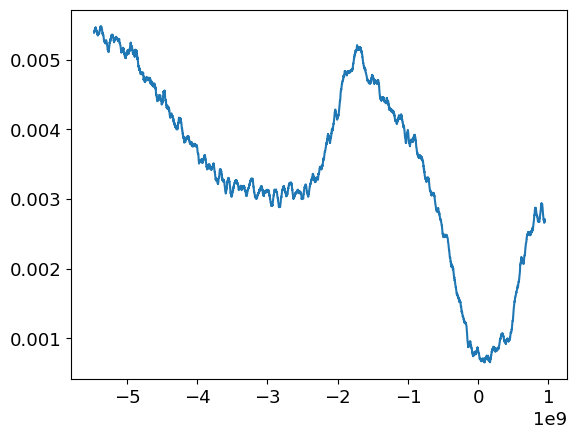

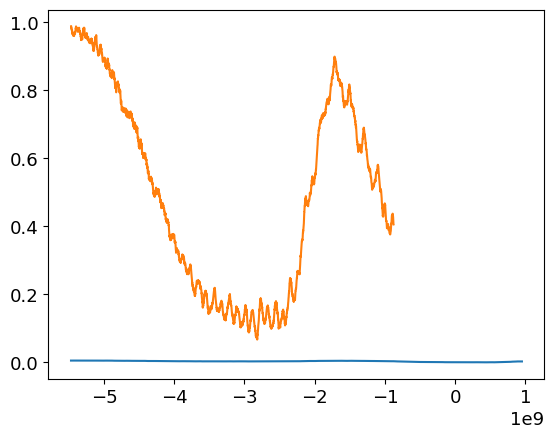

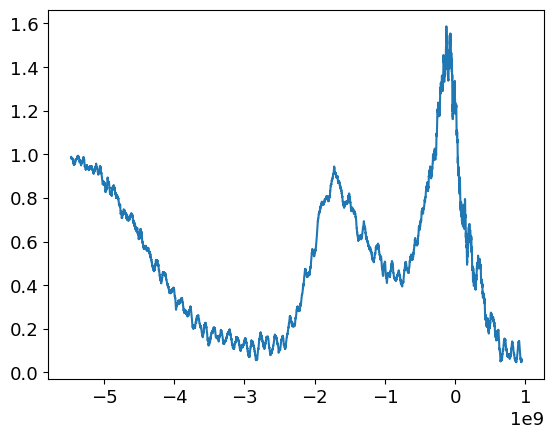

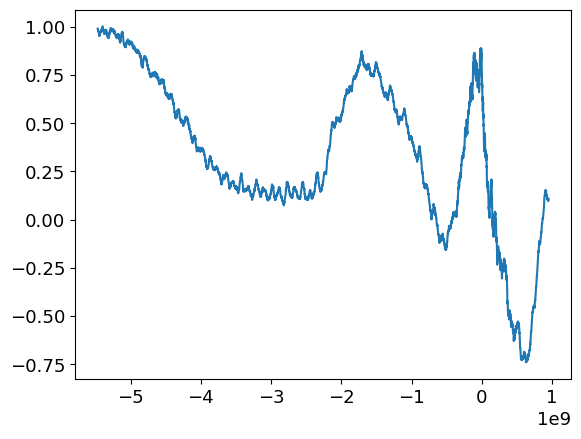

In [75]:
#This cell is changed in v1.3 so that we calculate the standard deviation in the moving average of the transmission
#instead of using the standard deviation for the non-averaged data 

#Cleaning up data traces

#Cleaning up data traces by taking moving averages for the absorption data 

df12 = pd.DataFrame(MeanAmplitudeOfCHSum1and3Peak12dT, TimeToFrequency)
df_mva12 = df12.rolling(30, axis=0).mean()  # moving average with a window size of 

df14 = pd.DataFrame(MeanAmplitudeOfCHSum1and3Peak22dT, TimeToFrequency)
df_mva14 = df14.rolling(30, axis=0).mean()  # moving average with a window size of 

df_mva12.plot(legend = False);
df_mva14.plot(legend = False);

#Cleaning up data traces by taking moving averages for the calculated transmission data

df15 = pd.DataFrame(TransmissionRatioFirstMeanNoSinglePhoton, TimeToFrequencyNoSinglePhoton)
df_mva15 = df15.rolling(30).mean()  # moving average with a window size of 

df16 = pd.DataFrame(TransmissionRatioSecondMeanNoSinglePhoton, TimeToFrequencyNoSinglePhoton)
df_mva16 = df16.rolling(30).mean()  # moving average with a window size of 

#Calculating the average of the two transmission ratios and then finding their mean and standard deviation 

AverageTransmissionRatio = (TransmissionRatioFirst+TransmissionRatioSecond)/2

AverageTransmissionRatioMean = AverageTransmissionRatio.mean(axis=0) #find the mean of each column 
AverageTransmissionRatiostd = AverageTransmissionRatio.std(axis=0) #find the mean of each column

AverageTransmissionRatioMeanNoSinglePhoton = np.delete(AverageTransmissionRatioMean, IndicesThroughPeakInTermsOfControlPeaks2)
AverageTransmissionRatiostdNoSinglePhoton = np.delete(AverageTransmissionRatiostd, IndicesThroughPeakInTermsOfControlPeaks2)

print(AverageTransmissionRatioMean)
print(AverageTransmissionRatiostd)

#AverageTransmissionRatioMeanNoSinglePhoton = (TransmissionRatioFirstMeanNoSinglePhoton+TransmissionRatioSecondMeanNoSinglePhoton)/2

df171 = pd.DataFrame({"G": AverageTransmissionRatioMeanNoSinglePhoton})
df172 = pd.DataFrame({"H": TimeToFrequencyNoSinglePhoton})

#we calculate the standard deviation in the averaged transmission by squaring all the standard deviation values
#we then sum them, square root the sum of the squared values and divide by the number of points 

df173 = pd.DataFrame({"K":  AverageTransmissionRatiostdNoSinglePhoton**2})

print(AverageTransmissionRatiostdNoSinglePhoton,'AverageTransmissionRatiostdNoSinglePhoton')
print(df173,'df173')

Windowsize = 30

df_mva171 = df171.rolling(Windowsize).mean()  # moving average with a window size of 
df_mva173 = df173.rolling(Windowsize).sum()
df_mva173Mean = (df_mva173)**0.5/Windowsize
df17 =  pd.concat([df_mva171, df172,df_mva173Mean], axis=1)
print(df17,'df17')


print(df_mva173,'df_mva173')
print(df_mva173Mean,'df_mva173Mean')

#Defining the new STD for the averaged transmission

AverageTransmissionRatiostdNoSinglePhoton = df17['K'].to_numpy() 

AverageTransmissionRatioMeanNoSinglePhotonmva = df17['G'].to_numpy() 

TimeToFrequencyNoSinglePhotonmva = df17['H'].to_numpy()

plt.plot(TimeToFrequencyNoSinglePhotonmva,AverageTransmissionRatioMeanNoSinglePhotonmva)

#Can also include the single photon resonance 

df18 = pd.DataFrame(TransmissionRatioFirstMean, TimeToFrequency)
df_mva18 = df18.rolling(30).mean()  # moving average with a window size of 

df19 = pd.DataFrame(TransmissionRatioSecondMean, TimeToFrequency)
df_mva19 = df19.rolling(30).mean()  # moving average with a window size of 

df_mva18.plot(legend = False);
df_mva19.plot(legend = False);

#not sure why the two detectors look completely different at the single photon resonance...
#I think it's because the powers are very small due to the single photon resonance causing very high loss
#so any smaller errors and the value of the transmission can easily switch between 1 and 0 

#we want to be able to plot the standard deviation and mean for the transmission constants 

(-5.5, 1.0)

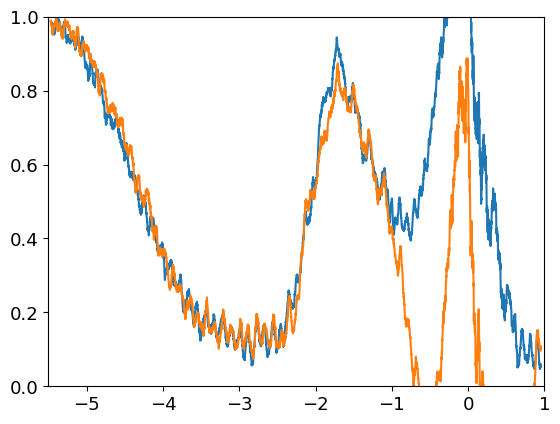

In [76]:
df_mva18np = df_mva18.to_numpy() 
df_mva19np = df_mva19.to_numpy() 

plt.plot(TimeToFrequency*10**-9, df_mva18np)
plt.plot(TimeToFrequency*10**-9, df_mva19np)

plt.ylim(0,1)
plt.xlim(-5.5,1)

[       nan        nan        nan ... 0.40860064 0.40659676 0.4059029 ]


Text(0, 0.5, 'Transmission constant')

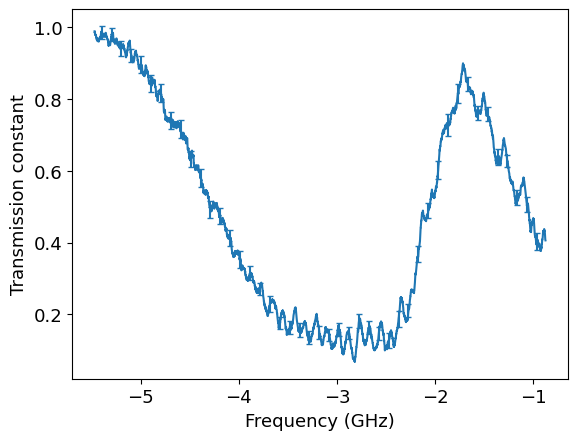

In [77]:
#plotting the moving average of the mean transmission with error bars 

AverageTransmissionRatioMeanNoSinglePhoton_mva = df_mva171["G"].to_numpy() 
print(AverageTransmissionRatioMeanNoSinglePhoton_mva)

plt.errorbar(TimeToFrequencyNoSinglePhoton*10**-9, AverageTransmissionRatioMeanNoSinglePhoton_mva,yerr=AverageTransmissionRatiostdNoSinglePhoton,errorevery=100, capsize =2)

plt.xlabel("Frequency (GHz)")

plt.ylabel("Transmission constant")
#plt.savefig('AverageTransmissionConstantOverBothDetectorsNoSinglePhotonLine.png', dpi=400)

#something of note is that we might have observed some LIAD near the single photon resonance
#there is a long lived increase in absorption after the control field is turned off when we are on single photon resonance
#this is likely due to the strong control field causing desorption of rubidium from the end faces of the vapour cell

[0.19085056 0.13673593 0.26928218 ... 0.16068386 0.16270628 0.31055432] DeltaPhiCFirstPeak3std
[0.08533696 0.21906794 0.         ... 0.32126064 0.34973605 0.12621656] DeltaPhiCFirstPeak2nd3std
           A             B         C
0   0.653233 -5.494102e+09  0.095861
1   0.857290 -5.371096e+09  0.192618
2   0.694447 -5.247081e+09  0.297070
3   0.900763 -5.108950e+09  0.133678
4   0.814919 -5.015184e+09  0.148922
..       ...           ...       ...
78  2.763341 -1.369358e+09  0.121233
79  2.763618 -1.268534e+09  0.186736
80  2.784553 -1.156618e+09  0.050799
81  2.821642 -1.056802e+09  0.288315
82  2.469677 -9.489193e+08  0.320847

[83 rows x 3 columns]
           A             B         C
0   0.653233 -5.494102e+09  0.095861
41  0.669955 -5.471921e+09  0.076889
1   0.857290 -5.371096e+09  0.192618
42  0.736577 -5.348913e+09  0.171650
2   0.694447 -5.247081e+09  0.297070
..       ...           ...       ...
80  2.784553 -1.156618e+09  0.050799
39  2.618002 -1.068901e+09  0.227852
81  2.8

G:\Users\willd\anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


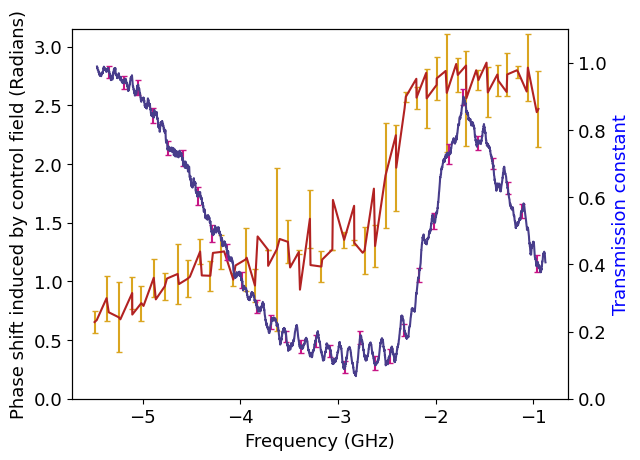

In [78]:
#Ideally for each set of experimental parameters we want a single line for the transmission constant
#combining the phase shift data for both peaks and then plotting along with error bars and transmission data

#combining the phase shift data for both peaks

peaksDeltaPhiCBoth = np.concatenate((ModDeltaPhiCFirstPeakMean[peaksDeltaPhiCFirst],ModDeltaPhiCSecondPeakMean[peaksDeltaPhiCSecond]), axis=None)
  
peaksDeltaPhiCBotht = np.concatenate((TimeToFrequency[peaksDeltaPhiCFirst],TimeToFrequency[peaksDeltaPhiCSecond]), axis=None)
 
#converting into pandas data frame     
    
dfphi11 = pd.DataFrame({"A": peaksDeltaPhiCBoth})
dftime = pd.DataFrame({"B": peaksDeltaPhiCBotht})

DeltaPhiCFirstPeak3std = np.nanstd(ArcCos,axis=0)
DeltaPhiCFirstPeak2nd3std = np.nanstd(ArcCos2nd,axis=0)

DeltaPhiCFirstPeak3std = DeltaPhiCFirstPeak3std.flatten()
DeltaPhiCFirstPeak2nd3std = DeltaPhiCFirstPeak2nd3std.flatten()

print(DeltaPhiCFirstPeak3std,'DeltaPhiCFirstPeak3std')
print(DeltaPhiCFirstPeak2nd3std,'DeltaPhiCFirstPeak2nd3std')

peaksDeltaPhiCBothstd = peaksDeltaPhiCBoth = np.concatenate((DeltaPhiCFirstPeak3std[peaksDeltaPhiCFirst],DeltaPhiCFirstPeak2nd3std[peaksDeltaPhiCSecond]), axis=None)

dfphi11std = pd.DataFrame({"C": peaksDeltaPhiCBothstd})

#combining the columns into one data frame

result11 = pd.concat([dfphi11, dftime, dfphi11std], axis=1)

print(result11)

#sorting the values by detuning

result12 = result11.sort_values('B')

print(result12)

#converting back to numpy and plotting

AverageModDeltaPhiC = result12['A'].to_numpy() 

AverageModDeltaPhiCStd = result12['C'].to_numpy() 

AverageModDeltaPhiCt = result12['B'].to_numpy() 

#plotting dual y-axes figure for transmission and phase shift 

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()

ax2.errorbar(TimeToFrequencyNoSinglePhoton*10**-9, AverageTransmissionRatioMeanNoSinglePhoton_mva,yerr=AverageTransmissionRatiostdNoSinglePhoton,errorevery=150, capsize =2, ecolor='mediumvioletred',c='darkslateblue')

ax1.errorbar((AverageModDeltaPhiCt)*10**-9, AverageModDeltaPhiC,c='firebrick', yerr =AverageModDeltaPhiCStd, errorevery=2,capsize =2, ecolor='goldenrod')

ax1.set_xlabel("Frequency (GHz)")

ax1.set_ylabel("Phase shift induced by control field (Radians)")
ax2.set_ylabel('Transmission constant', color='b')

ax2.set_ylim([0, 1.1])
ax1.set_ylim([0, 3.15])

#plt.savefig('Spectra of phase changes and transmission with errors 193.1694 THz control sigma+ 47mW new.png', dpi=400)

plt.show()


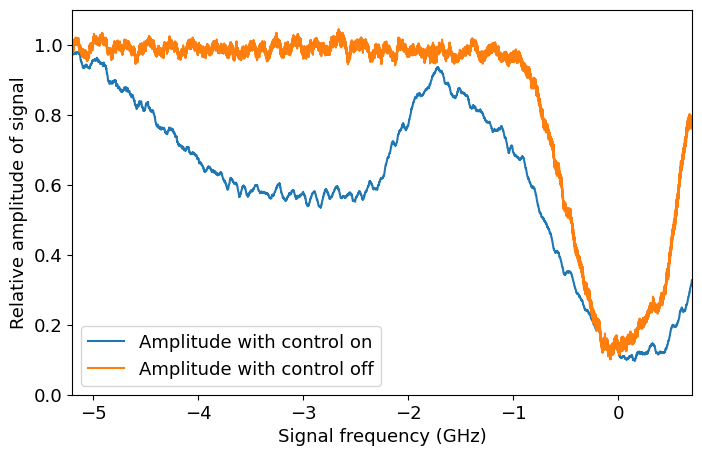

In [84]:
fig, ax = plt.subplots()

df3timemva = df_mva3['Time'].to_numpy() 

df3Amplitudemva = df_mva3['MeanAmplitudeOfCHSum1and3Peak12dT'].to_numpy() 

df4timemva = df_mva4['Time'].to_numpy() 

df4Amplitudemva = df_mva4['MeanAmplitudeOfCHSum1and3Peak22dT'].to_numpy() 

df4Amplitudemvamean = (df4Amplitudemva+df3Amplitudemva)/2

df4Amplitudemvamean1, = ax.plot(df4timemva*10**-9, df4Amplitudemvamean/0.00545)
yCHSum1and3filt1, = ax.plot(TimeToFrequencyAllData*10**-9, yCHSum1and3filt/0.00545)

ax.legend([df4Amplitudemvamean1, yCHSum1and3filt1], ['Amplitude with control on','Amplitude with control off'], loc='lower left')

plt.xlabel("Signal frequency (GHz)")
plt.ylabel("Relative amplitude of signal")
plt.xlim([-5.2, 0.7])
plt.ylim([0, 1.1])

fig.patch.set_facecolor('white')
fig.patch.set_alpha(1)

fig.set_figheight(5)
fig.set_figwidth(8)

#fig.tight_layout() #makes the margins around the figure tight to the figure 

#plt.savefig('Spectra amplitude with and without control 193.1694 THz 47mW control with SP new.png', dpi=400, bbox_inches='tight', pad_inches = 0)
#plt.savefig('Spectra amplitude with and without control 193.1694 THz 47mW control with SP new.pdf', dpi=400, bbox_inches='tight', pad_inches = 0)


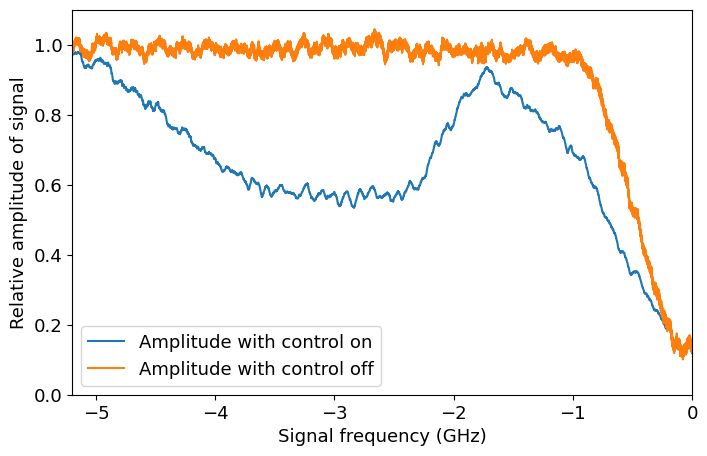

In [85]:
fig, ax = plt.subplots()

df3timemva = df_mva3['Time'].to_numpy() 

df3Amplitudemva = df_mva3['MeanAmplitudeOfCHSum1and3Peak12dT'].to_numpy() 

df4timemva = df_mva4['Time'].to_numpy() 

df4Amplitudemva = df_mva4['MeanAmplitudeOfCHSum1and3Peak22dT'].to_numpy() 

df4Amplitudemvamean = (df4Amplitudemva+df3Amplitudemva)/2

df4Amplitudemvamean1, = ax.plot(df4timemva*10**-9, df4Amplitudemvamean/0.00545)
yCHSum1and3filt1, = ax.plot(TimeToFrequencyAllData*10**-9, yCHSum1and3filt/0.00545)

ax.legend([df4Amplitudemvamean1, yCHSum1and3filt1], ['Amplitude with control on','Amplitude with control off'], loc='lower left')

plt.xlabel("Signal frequency (GHz)")
plt.ylabel("Relative amplitude of signal")
plt.xlim([-5.2, 0])
plt.ylim([0, 1.1])

fig.set_figheight(5)
fig.set_figwidth(8)

fig.patch.set_facecolor('white')
fig.patch.set_alpha(1)

#fig.tight_layout() #makes the margins around the figure tight to the figure 

#plt.savefig('Spectra amplitude with and without control 193.1694 THz 47mW control without SP new.png', dpi=400, bbox_inches='tight', pad_inches = 0)
#plt.savefig('Spectra amplitude with and without control 193.1694 THz 47mW control without SP new.pdf', dpi=400, bbox_inches='tight', pad_inches = 0)


In [87]:
def mean_with_nan_handling(data):
    # Calculate the mean along each column
    column_means = np.nanmean(data, axis=0)

    # Create a mask to filter out columns with less than 3 valid values (not NaN)
    valid_mask = np.sum(~np.isnan(data), axis=0) >= 2

    # Apply the mask to get the final mean values
    final_means = np.where(valid_mask, column_means, np.nan)

    return final_means

def std_with_nan_handling(data):
    # Create a mask to filter out columns with less than 3 valid values (not NaN)
    valid_mask = np.sum(~np.isnan(data), axis=0) >= 2

    # Apply the mask to both the data and means to get the final std values
    valid_data = data[:, valid_mask]
    final_stds = np.nanstd(valid_data, axis=0)

    # Create an array with NaN values for invalid columns
    result_std = np.full(data.shape[1], np.nan)
    result_std[valid_mask] = final_stds

    return result_std


def remove_nan_indices(indices, values):
    nan_indices = np.where(np.isnan(values))[0]

    # Create a mask to identify indices to keep
    mask = ~np.isin(indices, nan_indices)

    # Filter the indices array using the mask
    filtered_indices = indices[mask]

    return filtered_indices

#Replacing std values with less than 2 values with nan and then deleting the single photon peak

std_values = std_with_nan_handling(ArcCos)
print(std_values)

std_valuesChopped = np.delete(std_values, IndicesThroughPeakInTermsOfControlPeaks2)

#Replacing std values with less than 2 values with nan and then deleting the single photon peak

std_values2nd = std_with_nan_handling(ArcCos2nd)
print(std_values2nd)

std_valuesChopped2nd = np.delete(std_values2nd, IndicesThroughPeakInTermsOfControlPeaks2)

ModDeltaPhiCFirstPeakMean = (DeltaPhiCFirstPeak3Mean**2)**0.5
ModDeltaPhiCSecondPeakMean = (DeltaPhiCFirstPeak2nd3Mean**2)**0.5

print(peaksDeltaPhiCFirst)
print(std_valuesChopped)
print(len(peaksDeltaPhiCFirst))
print(len(std_valuesChopped))

#removing the indices from the index arrays that correspond to nan values in the std arrays

peaksDeltaPhiCFirstChopped = remove_nan_indices(peaksDeltaPhiCFirst, std_valuesChopped) #delete indices where there is nan values from index array
peaksDeltaPhiCSecondChopped = remove_nan_indices(peaksDeltaPhiCSecond, std_valuesChopped2nd)

#forming the arrays with the nan values removed for the phase shift mean, standard deviation ,and time values 

peaksDeltaPhiCBoth = np.concatenate((ModDeltaPhiCFirstPeakMean[peaksDeltaPhiCFirstChopped],ModDeltaPhiCSecondPeakMean[peaksDeltaPhiCSecondChopped]), axis=None)

#re-assign these variables to overwrite since they are used later on

peaksDeltaPhiCFirst = peaksDeltaPhiCFirstChopped
peaksDeltaPhiCSecond = peaksDeltaPhiCSecondChopped

print(ModDeltaPhiCFirstPeakMean[peaksDeltaPhiCFirstChopped])
print(ModDeltaPhiCSecondPeakMean[peaksDeltaPhiCSecondChopped])

peaksDeltaPhiCBotht = np.concatenate((TimeToFrequency[peaksDeltaPhiCFirstChopped],TimeToFrequency[peaksDeltaPhiCSecondChopped]), axis=None)

peaksDeltaPhiCBothstd = np.concatenate((DeltaPhiCFirstPeak3std[peaksDeltaPhiCFirstChopped],DeltaPhiCFirstPeak2nd3std[peaksDeltaPhiCSecondChopped]), axis=None)


print(peaksDeltaPhiCBoth)

[0.19085056 0.13673593 0.26928218 ... 0.16068386 0.16270628 0.31055432]
[0.08533696 0.21906794        nan ... 0.32126064 0.34973605 0.12621656]
[   5  127  250  387  480  606  718  849  950 1077 1181 1293 1414 1541
 1634 1766 1856 1969 2091 2192 2309 2426 2641 2728 2842 2945 3065 3154
 3275 3378 3479 3582 3694 3781 3904 3999 4106 4190 4294 4394 4496]
[0.19085056 0.13673593 0.26928218 ... 0.21557169 0.16544023 0.46164543]
41
4585
[0.65323281 0.85728987 0.69444678 0.90076253 0.81491906 1.03043473
 0.95797407 1.06337332 1.02260866 1.25431083 1.04788966 1.25150611
 1.01532329 1.18813254 0.96436878 1.273055   1.33680963 0.92950061
 1.53356267 1.12631834 1.69413603 1.64398277 1.24396    1.81894349
 2.24534166 2.47650729 2.5656967  2.55984117 2.67444254 2.60667455
 2.75941187 2.55989216 2.71568196 2.61016806 2.71009359 2.614327
 2.79929124 2.61800158 2.44228404]
[0.66995504 0.73657663 0.67683085 0.71732649 0.79076916 0.84675448
 1.02426566 0.97723461 1.03964472 1.05067184 1.24278786 1.2560042

[0.19085056 0.13673593 0.26928218 ... 0.16068386 0.16270628 0.31055432] DeltaPhiCFirstPeak3std
[0.08533696 0.21906794 0.         ... 0.32126064 0.34973605 0.12621656] DeltaPhiCFirstPeak2nd3std
           A             B         C
0   0.653233 -5.494102e+09  0.095861
1   0.857290 -5.371096e+09  0.192618
2   0.694447 -5.247081e+09  0.297070
3   0.900763 -5.108950e+09  0.133678
4   0.814919 -5.015184e+09  0.148922
..       ...           ...       ...
75  2.763341 -1.369358e+09  0.121233
76  2.763618 -1.268534e+09  0.186736
77  2.784553 -1.156618e+09  0.050799
78  2.821642 -1.056802e+09  0.288315
79  2.469677 -9.489193e+08  0.320847

[80 rows x 3 columns]
           A             B         C
0   0.653233 -5.494102e+09  0.095861
39  0.669955 -5.471921e+09  0.076889
1   0.857290 -5.371096e+09  0.192618
40  0.736577 -5.348913e+09  0.171650
2   0.694447 -5.247081e+09  0.297070
..       ...           ...       ...
77  2.784553 -1.156618e+09  0.050799
37  2.618002 -1.068901e+09  0.227852
78  2.8

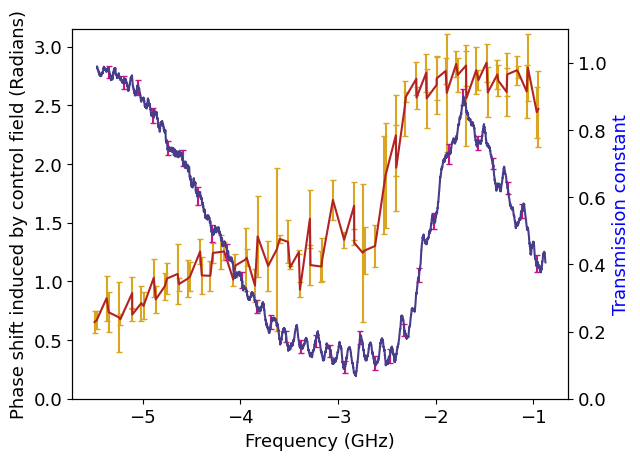

In [88]:
#converting into pandas data frame     
 
dfphi11 = pd.DataFrame({"A": peaksDeltaPhiCBoth})
dftime = pd.DataFrame({"B": peaksDeltaPhiCBotht})

print(DeltaPhiCFirstPeak3std,'DeltaPhiCFirstPeak3std')
print(DeltaPhiCFirstPeak2nd3std,'DeltaPhiCFirstPeak2nd3std')

dfphi11std = pd.DataFrame({"C": peaksDeltaPhiCBothstd})

#combining the columns into one data frame

result11 = pd.concat([dfphi11, dftime, dfphi11std], axis=1)

print(result11)

#sorting the values by detuning

result12 = result11.sort_values('B')

print(result12)

#converting back to numpy and plotting

AverageModDeltaPhiC = result12['A'].to_numpy() 

AverageModDeltaPhiCStd = result12['C'].to_numpy() 

AverageModDeltaPhiCt = result12['B'].to_numpy() 

#plotting dual y-axes figure for transmission and phase shift 

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()

ax2.errorbar(TimeToFrequencyNoSinglePhoton*10**-9, AverageTransmissionRatioMeanNoSinglePhoton_mva,yerr=AverageTransmissionRatiostdNoSinglePhoton,errorevery=150, capsize =2, ecolor='mediumvioletred',c='darkslateblue')

ax1.errorbar((AverageModDeltaPhiCt)*10**-9, AverageModDeltaPhiC,c='firebrick', yerr =AverageModDeltaPhiCStd, errorevery=1,capsize =2, ecolor='goldenrod')

ax1.set_xlabel("Frequency (GHz)")

ax1.set_ylabel("Phase shift induced by control field (Radians)")
ax2.set_ylabel('Transmission constant', color='b')

#plt.xlim([-6, -1])
ax2.set_ylim([0, 1.1])
ax1.set_ylim([0, 3.15])

plt.savefig('Spectra of phase changes and transmission with errors 193.1694 THz control sigma+ 47mW new.png', dpi=400)

plt.show()

           L             M         O
0        NaN -5.493370e+09       NaN
39       NaN -5.471189e+09       NaN
1   0.840192 -5.370365e+09  0.189434
40  0.717408 -5.348182e+09  0.167744
2   0.672767 -5.246349e+09  0.288222
..       ...           ...       ...
77  1.449061 -1.155886e+09  0.060605
37  1.336714 -1.068169e+09  0.126548
78  1.423848 -1.056070e+09  0.156149
38  0.977977 -9.653280e+08  0.104821
79  0.969561 -9.481877e+08  0.140126

[80 rows x 3 columns]


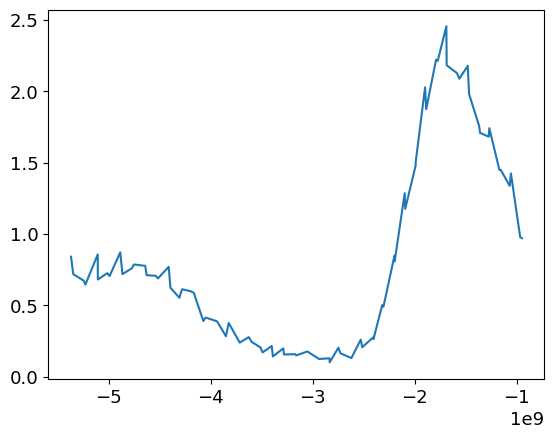

In [89]:
#Calculating the product of the phase shift and transmission for the entire spectra 

ProductOfTransmissionPhaseShiftFirst = AverageTransmissionRatioMeanNoSinglePhoton_mva[peaksDeltaPhiCFirst]*ModDeltaPhiCFirstPeakMean[peaksDeltaPhiCFirst]
ProductOfTransmissionPhaseShiftSecond = AverageTransmissionRatioMeanNoSinglePhoton_mva[peaksDeltaPhiCSecond]*ModDeltaPhiCSecondPeakMean[peaksDeltaPhiCSecond]

ProductOfTransmissionPhaseShiftFirstSTD = (((AverageTransmissionRatiostdNoSinglePhoton[peaksDeltaPhiCFirst]/AverageTransmissionRatioMeanNoSinglePhoton_mva[peaksDeltaPhiCFirst])**2+(DeltaPhiCFirstPeak3std[peaksDeltaPhiCFirst]/ModDeltaPhiCFirstPeakMean[peaksDeltaPhiCFirst])**2)**0.5)*ProductOfTransmissionPhaseShiftFirst
ProductOfTransmissionPhaseShiftSecondSTD = (((AverageTransmissionRatiostdNoSinglePhoton[peaksDeltaPhiCSecond]/ AverageTransmissionRatioMeanNoSinglePhoton_mva[peaksDeltaPhiCSecond])**2+(DeltaPhiCFirstPeak2nd3std[peaksDeltaPhiCSecond]/ModDeltaPhiCSecondPeakMean[peaksDeltaPhiCSecond])**2)**0.5)*ProductOfTransmissionPhaseShiftSecond

ProductOfTransmissionPhaseShiftBoth = np.concatenate((ProductOfTransmissionPhaseShiftFirst,ProductOfTransmissionPhaseShiftSecond), axis=None)
  
ProductOfTransmissionPhaseShiftBothFreq = np.concatenate((TimeToFrequencyNoSinglePhoton[peaksDeltaPhiCFirst],TimeToFrequencyNoSinglePhoton[peaksDeltaPhiCSecond]), axis=None)

STDProductOfTransmissionPhaseShiftBoth = np.concatenate((ProductOfTransmissionPhaseShiftFirstSTD,ProductOfTransmissionPhaseShiftSecondSTD), axis=None)

dfphi20 = pd.DataFrame({"L": ProductOfTransmissionPhaseShiftBoth})
df20freq = pd.DataFrame({"M": ProductOfTransmissionPhaseShiftBothFreq})
dfproductSTD = pd.DataFrame({"O": STDProductOfTransmissionPhaseShiftBoth})

result111 = pd.concat([dfphi20,df20freq,dfproductSTD], axis=1)

result122 = result111.sort_values('M')

print(result122)


ProductOfTransmissionPhaseShiftBoth2 = result122['L'].to_numpy() 

ProductOfTransmissionPhaseShiftBothFreq2 = result122['M'].to_numpy() 

STDProductOfTransmissionPhaseShiftBoth2 = result122['O'].to_numpy() 

plt.plot(ProductOfTransmissionPhaseShiftBothFreq2,ProductOfTransmissionPhaseShiftBoth2)


In [90]:
#Export data from analysis into a csv that we can then read into the script for plotting all data 

#Make a pandas dataframe with all the data we want to export, and then export into a csv

ExportDF1 = result12

#print(result12)
#print(df17)

ExportDF = pd.concat([result12, df17,result122], axis=1)
ExportDF = ExportDF.rename(columns={'A': "AmplitudePeaksDeltaPhiCBoth", 'B': "FrequencyPeaksDeltaPhiCBoth", 'C': "PeaksDeltaPhiCBothSTD", 'G': "AverageTransmissionRatioMeanNoSinglePhoton", 'H': "FrequencyNoSinglePhoton", 'K': "AverageTransmissionRatioNoSinglePhotonSTD", 'O': 'STDProductOfTransmissionPhaseShiftBoth'})
ExportDF = ExportDF.sort_values('FrequencyNoSinglePhoton')

print(ExportDF)

ExportDF.to_csv('Analysed data 97.6C 193.1694 THz control 1 MHz 47mW 4ns and CW 1.6mW sigma+ v2.csv', encoding='utf-8')

print(len(peaksDeltaPhiCFirst))
print(len(peaksDeltaPhiCSecond))


      AmplitudePeaksDeltaPhiCBoth  FrequencyPeaksDeltaPhiCBoth  \
0                        0.653233                -5.494102e+09   
1                        0.857290                -5.371096e+09   
2                        0.694447                -5.247081e+09   
3                        0.900763                -5.108950e+09   
4                        0.814919                -5.015184e+09   
...                           ...                          ...   
4580                          NaN                          NaN   
4581                          NaN                          NaN   
4582                          NaN                          NaN   
4583                          NaN                          NaN   
4584                          NaN                          NaN   

      PeaksDeltaPhiCBothSTD  AverageTransmissionRatioMeanNoSinglePhoton  \
0                  0.095861                                         NaN   
1                  0.192618                              